In [1088]:
# Importing Dependencies

import psycopg2
import configparser
import time
import numpy                as np
import pandas               as pd
import seaborn              as sns
import plotly.express       as px
import matplotlib.pyplot    as plt
import tensorflow           as tf
import plotly.graph_objects as go


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing      import LabelEncoder, MinMaxScaler, label_binarize
from sklearn.linear_model       import LogisticRegression, LogisticRegressionCV
from sklearn.metrics            import precision_recall_fscore_support as score
from sklearn.metrics            import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc,recall_score, precision_score, f1_score, classification_report,fbeta_score
from sklearn.model_selection    import GridSearchCV, cross_val_score
from sklearn.tree               import DecisionTreeClassifier
from sklearn.ensemble           import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm                import SVC
from sklearn.neighbors          import KNeighborsClassifier
from tensorflow                 import keras
from plotly.subplots            import make_subplots
from sklearn                    import model_selection




## DATABASE CONNECTION

In [1089]:

config = configparser.ConfigParser()
config.read('../../my_config.ini')

config.sections()
DBPass = config.get('rds', 'password')

# AWS CONNECTION

engine = psycopg2.connect(
    database="project4",
    user="postgres",
    password=DBPass,
    host="bootcampproject4.ceqr0hcm5qlq.us-east-1.rds.amazonaws.com",
    port='5432'
)


Query = "select * from telecom_customer_churn"

data_df = pd.io.sql.read_sql(Query, engine)
engine.close()


(data_df.head(2))


customerid  gender  age married  number_of_dependents          city  \
0  0002-ORFBO  Female   37     Yes                     0  Frazier Park   
1  0003-MKNFE    Male   46      No                     0      Glendale   

   zipcode   latitude  longtitude  numberofreferrals  ...  paymentmethod  \
0    93225  34.827662 -118.999073                  2  ...    Credit Card   
1    91206  34.162515 -118.203869                  0  ...    Credit Card   

  monthlycharge totalcharges  totalrefunds totalextradatacharges  \
0          65.6        593.3          0.00                   0.0   
1          -4.0        542.4         38.33                  10.0   

  totallongdistancecharges totalrevenue  customerstatus churncategory  \
0                   381.51       974.81          Stayed          None   
1                    96.21       610.28          Stayed          None   

  churnreason  
0        None  
1        None  

[2 rows x 38 columns]

The database is stored on Amazon services. 

<img src="images/AWS_RDS.png" alt="drawing" width="500"/>

## DATA CLEANING

In [1090]:
data_df = data_df[data_df['customerstatus'] != 'Joined']
data_df.head(2)

customerid  gender  age married  number_of_dependents          city  \
0  0002-ORFBO  Female   37     Yes                     0  Frazier Park   
1  0003-MKNFE    Male   46      No                     0      Glendale   

   zipcode   latitude  longtitude  numberofreferrals  ...  paymentmethod  \
0    93225  34.827662 -118.999073                  2  ...    Credit Card   
1    91206  34.162515 -118.203869                  0  ...    Credit Card   

  monthlycharge totalcharges  totalrefunds totalextradatacharges  \
0          65.6        593.3          0.00                   0.0   
1          -4.0        542.4         38.33                  10.0   

  totallongdistancecharges totalrevenue  customerstatus churncategory  \
0                   381.51       974.81          Stayed          None   
1                    96.21       610.28          Stayed          None   

  churnreason  
0        None  
1        None  

[2 rows x 38 columns]

In [1091]:
data_df['churncategory']                    = data_df['churncategory'].replace(np.nan,'satisfied')
data_df['internettype']                     = data_df['internettype'].replace(np.nan,'No')
data_df['multiplelines']                    = data_df['multiplelines'].replace(np.nan,'No')
data_df['avgmonthlylongdistancecharges']    = data_df['avgmonthlylongdistancecharges'].replace(np.nan,0)
data_df['avgmonthlygbdownload']             = data_df['avgmonthlygbdownload'].replace(np.nan,0)
data_df['internetservice']                  = data_df['internetservice'].replace(np.nan,'No')
data_df['onlinesecurity']                   = data_df['onlinesecurity'].replace(np.nan,'No')
data_df['onlinebackup']                     = data_df['onlinebackup'].replace(np.nan,'No')
data_df['deviceprotectionplan']             = data_df['deviceprotectionplan'].replace(np.nan,'No')
data_df['premiumtechsupport']               = data_df['premiumtechsupport'].replace(np.nan,'No')
data_df['streamingtv']                      = data_df['streamingtv'].replace(np.nan,'No')
data_df['streamingmusic']                   = data_df['streamingmusic'].replace(np.nan,'No')
data_df['unlimiteddata']                    = data_df['unlimiteddata'].replace(np.nan,'No')
data_df['streamingmovies']                  = data_df['streamingmovies'].replace(np.nan,'No')

In [1092]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6589 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customerid                     6589 non-null   object 
 1   gender                         6589 non-null   object 
 2   age                            6589 non-null   int64  
 3   married                        6589 non-null   object 
 4   number_of_dependents           6589 non-null   int64  
 5   city                           6589 non-null   object 
 6   zipcode                        6589 non-null   int64  
 7   latitude                       6589 non-null   float64
 8   longtitude                     6589 non-null   float64
 9   numberofreferrals              6589 non-null   int64  
 10  tenureinmonths                 6589 non-null   int64  
 11  offer                          6589 non-null   object 
 12  phoneservice                   6589 non-null   o

In [1093]:
data_df['totalcharges'] = pd.to_numeric(data_df.totalcharges, errors='coerce')
data_df.isnull().sum()

customerid                          0
gender                              0
age                                 0
married                             0
number_of_dependents                0
city                                0
zipcode                             0
latitude                            0
longtitude                          0
numberofreferrals                   0
tenureinmonths                      0
offer                               0
phoneservice                        0
avgmonthlylongdistancecharges       0
multiplelines                       0
internetservice                     0
internettype                        0
avgmonthlygbdownload                0
onlinesecurity                      0
onlinebackup                        0
deviceprotectionplan                0
premiumtechsupport                  0
streamingtv                         0
streamingmovies                     0
streamingmusic                      0
unlimiteddata                       0
contract    

In [1094]:
data_df.shape

(6589, 38)

## DATA VISUALIZATION  AND DETAILED ANALYSIS

This section is for processing data set to identify which columns in the data set to take for analysis and which columns provides more waigtage for ML.

In [1095]:
fig0 = px.scatter_mapbox(data_df, lat="latitude", lon="longtitude", color="totalcharges", size="age", animation_frame="tenureinmonths",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=4,
                  mapbox_style="carto-positron")
fig0.show()

In [1096]:
fig = px.histogram(data_df, x='totalcharges')
fig

In [1097]:
df_num      = data_df.select_dtypes('number')
df_object   = data_df.select_dtypes('object')
fig1        = px.histogram(data_df, x="totalcharges", color="gender", marginal="rug", hover_data=df_object.columns)
fig1.show()

In [1098]:

bins = [19,30,45,60,80]
names = ['19-30','30-45','45-60','60-80']
df_object['AgeRange'] = pd.cut(data_df['age'],bins, labels=names,include_lowest=True)
fig4 =px.box(df_object.join(df_num),x='AgeRange',y='avgmonthlygbdownload', color ='customerstatus')
fig4

c:\Users\User\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1099]:
fig5 =px.box(df_object.join(df_num),x='AgeRange',y='tenureinmonths', color ='customerstatus')
fig5

In [1100]:
fig6 =px.box(df_object.join(df_num),x='gender',y='tenureinmonths', color ='customerstatus')
fig6

In [1101]:
fig8 = px.scatter_matrix(data_df, dimensions=["age", "monthlycharge", "tenureinmonths","avgmonthlylongdistancecharges"], color="customerstatus",width=1200, height=1200)
fig8.show()

## DATA PREPROCESING FOR MODELLING WITH GRAPHS TO HELP IN DECISION MAKING[Data exploration]

#### Feature Selection

Feature selection is one of the first and important steps while performing any machine learning task. A feature in case of a dataset simply means a column. When we get any dataset, not necessarily every column (feature) is going to have an impact on the output variable. If we add these irrelevant features in the model, it will just make the model worst (Garbage In Garbage Out). This gives rise to the need of doing feature selection.

When it comes to implementation of feature selection in Pandas, Numerical and Categorical features are to be treated differently. Here we will first discuss about Numeric feature selection. Hence before implementing the following methods, we need to make sure that the DataFrame only contains Numeric features. Also, the following methods are discussed for regression problem, which means both the input and output variables are continuous in nature.

In [1102]:
preprocessing_df = data_df.copy()
preprocessing_df = preprocessing_df.drop(['churnreason','customerid','city','totalrefunds','zipcode','latitude','longtitude','totalextradatacharges','totalrevenue'],axis=1)
preprocessing_df.head(2)

gender  age married  number_of_dependents  numberofreferrals  \
0  Female   37     Yes                     0                  2   
1    Male   46      No                     0                  0   

   tenureinmonths offer phoneservice  avgmonthlylongdistancecharges  \
0               9  None          Yes                          42.39   
1               9  None          Yes                          10.69   

  multiplelines  ... streamingmusic unlimiteddata        contract  \
0            No  ...             No           Yes        One Year   
1           Yes  ...            Yes            No  Month-to-Month   

  paperlessbilling paymentmethod monthlycharge totalcharges  \
0              Yes   Credit Card          65.6        593.3   
1               No   Credit Card          -4.0        542.4   

  totallongdistancecharges customerstatus churncategory  
0                   381.51         Stayed     satisfied  
1                    96.21         Stayed     satisfied  

[2 rows x 29 columns]

In [1103]:
def foo(x):
    if x == 'Stayed':
        return 0
    elif x == 'Churned':
        return 1
    else:
        return x
preprocessing_df['customerstatus']=preprocessing_df['customerstatus'].apply(lambda x : foo(x))
preprocessing_df.head(2)

gender  age married  number_of_dependents  numberofreferrals  \
0  Female   37     Yes                     0                  2   
1    Male   46      No                     0                  0   

   tenureinmonths offer phoneservice  avgmonthlylongdistancecharges  \
0               9  None          Yes                          42.39   
1               9  None          Yes                          10.69   

  multiplelines  ... streamingmusic unlimiteddata        contract  \
0            No  ...             No           Yes        One Year   
1           Yes  ...            Yes            No  Month-to-Month   

  paperlessbilling paymentmethod monthlycharge totalcharges  \
0              Yes   Credit Card          65.6        593.3   
1               No   Credit Card          -4.0        542.4   

  totallongdistancecharges customerstatus churncategory  
0                   381.51              0     satisfied  
1                    96.21              0     satisfied  

[2 rows x 29 columns]

<AxesSubplot:>

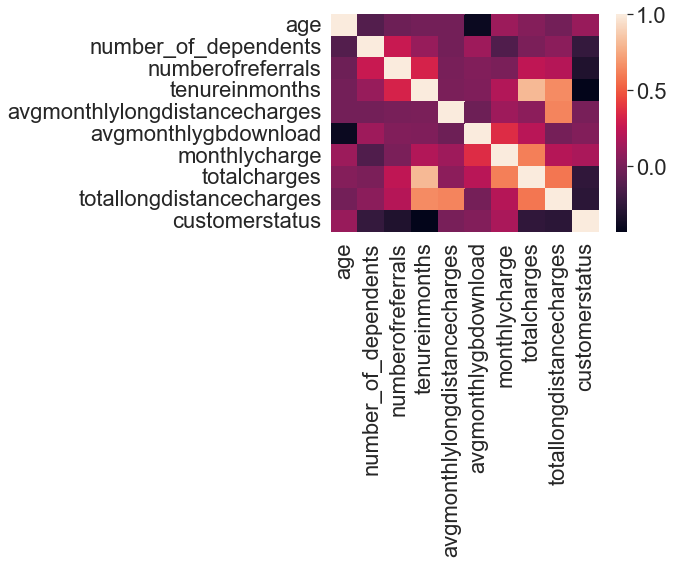

In [1104]:

corr= preprocessing_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [1105]:
preprocessing_df.nunique()

gender                              2
age                                62
married                             2
number_of_dependents               10
numberofreferrals                  12
tenureinmonths                     72
offer                               6
phoneservice                        2
avgmonthlylongdistancecharges    3452
multiplelines                       2
internetservice                     2
internettype                        4
avgmonthlygbdownload               50
onlinesecurity                      2
onlinebackup                        2
deviceprotectionplan                2
premiumtechsupport                  2
streamingtv                         2
streamingmovies                     2
streamingmusic                      2
unlimiteddata                       2
contract                            3
paperlessbilling                    2
paymentmethod                       3
monthlycharge                    1579
totalcharges                     6281
totallongdis

In [1106]:
print(preprocessing_df['customerstatus'].value_counts())
100. * preprocessing_df['customerstatus'].value_counts() / len(preprocessing_df['customerstatus'])

0    4720
1    1869
Name: customerstatus, dtype: int64


0    71.634542
1    28.365458
Name: customerstatus, dtype: float64

In [1107]:
type_ = ["No", "Yes"]
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Pie(labels=type_, values=preprocessing_df['customerstatus'].value_counts(), name="Churn"))

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Churn Distributions",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Churn Status', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

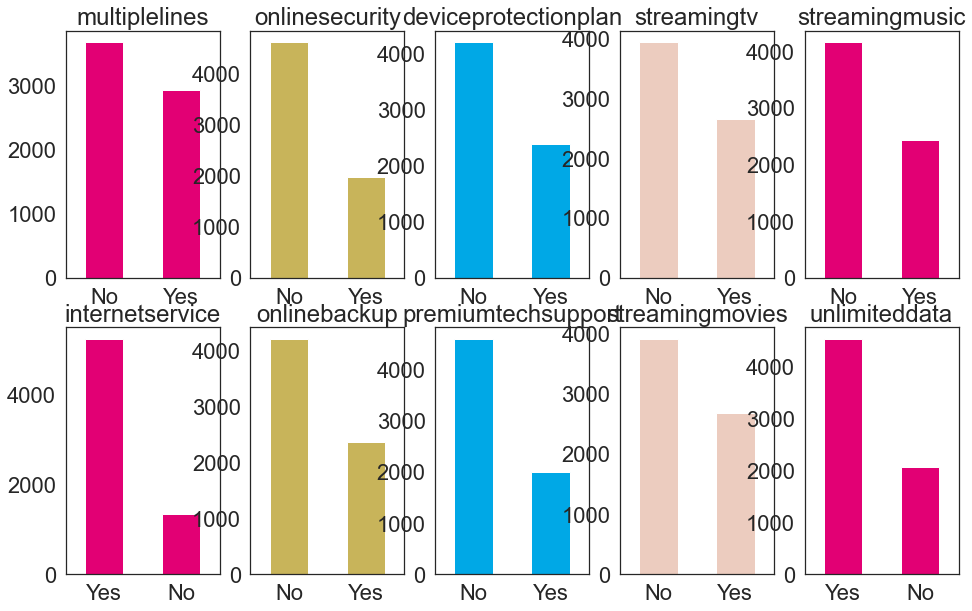

In [1108]:
#SUBPLOTS FOR SERVICE DATA

service_labels = ['multiplelines', 'internetservice','onlinesecurity',
                'onlinebackup','deviceprotectionplan',
                'premiumtechsupport','streamingtv','streamingmovies','streamingmusic','unlimiteddata']

# bar charts
fig3, axes = plt.subplots(nrows = 2, ncols = 5,figsize = (16,10))
for i, item in enumerate(service_labels):
    if i < 2:
        ax = preprocessing_df[item].value_counts().plot(kind = 'bar', ax=axes[i,0], rot = 0, color ='#e20074')
        ax.set_title(item)
    elif i >=2 and i < 4:
        ax = preprocessing_df[item].value_counts().plot(kind = 'bar', ax=axes[i-2,1], rot = 0,color ='#c8b45a')
        ax.set_title(item)
    elif i >=4 and i < 6:
        ax = preprocessing_df[item].value_counts().plot(kind = 'bar', ax=axes[i-4,2],rot = 0,color = '#00a8e6')
        ax.set_title(item)
    elif i >=6 and i < 8:
        ax = preprocessing_df[item].value_counts().plot(kind = 'bar', ax=axes[i-6,3],rot = 0,color = '#ecccbf')
        ax.set_title(item)
    elif i < 10:
        ax = preprocessing_df[item].value_counts().plot(kind = 'bar', ax=axes[i-8,4],rot = 0,color = '#e20074')
        ax.set_title(item)

# 4. Filter Method
Here we will first plot the Pearson correlation heatmap and see the correlation of independent variables with selected features. We will only select features which has correlation of above 0.5 (taking absolute value) with the output variable.

The correlation coefficient has values between -1 to 1 — A value closer to 0 implies weaker correlation (exact 0 implying no correlation) — A value closer to 1 implies stronger positive correlation — A value closer to -1 implies stronger negative correlation

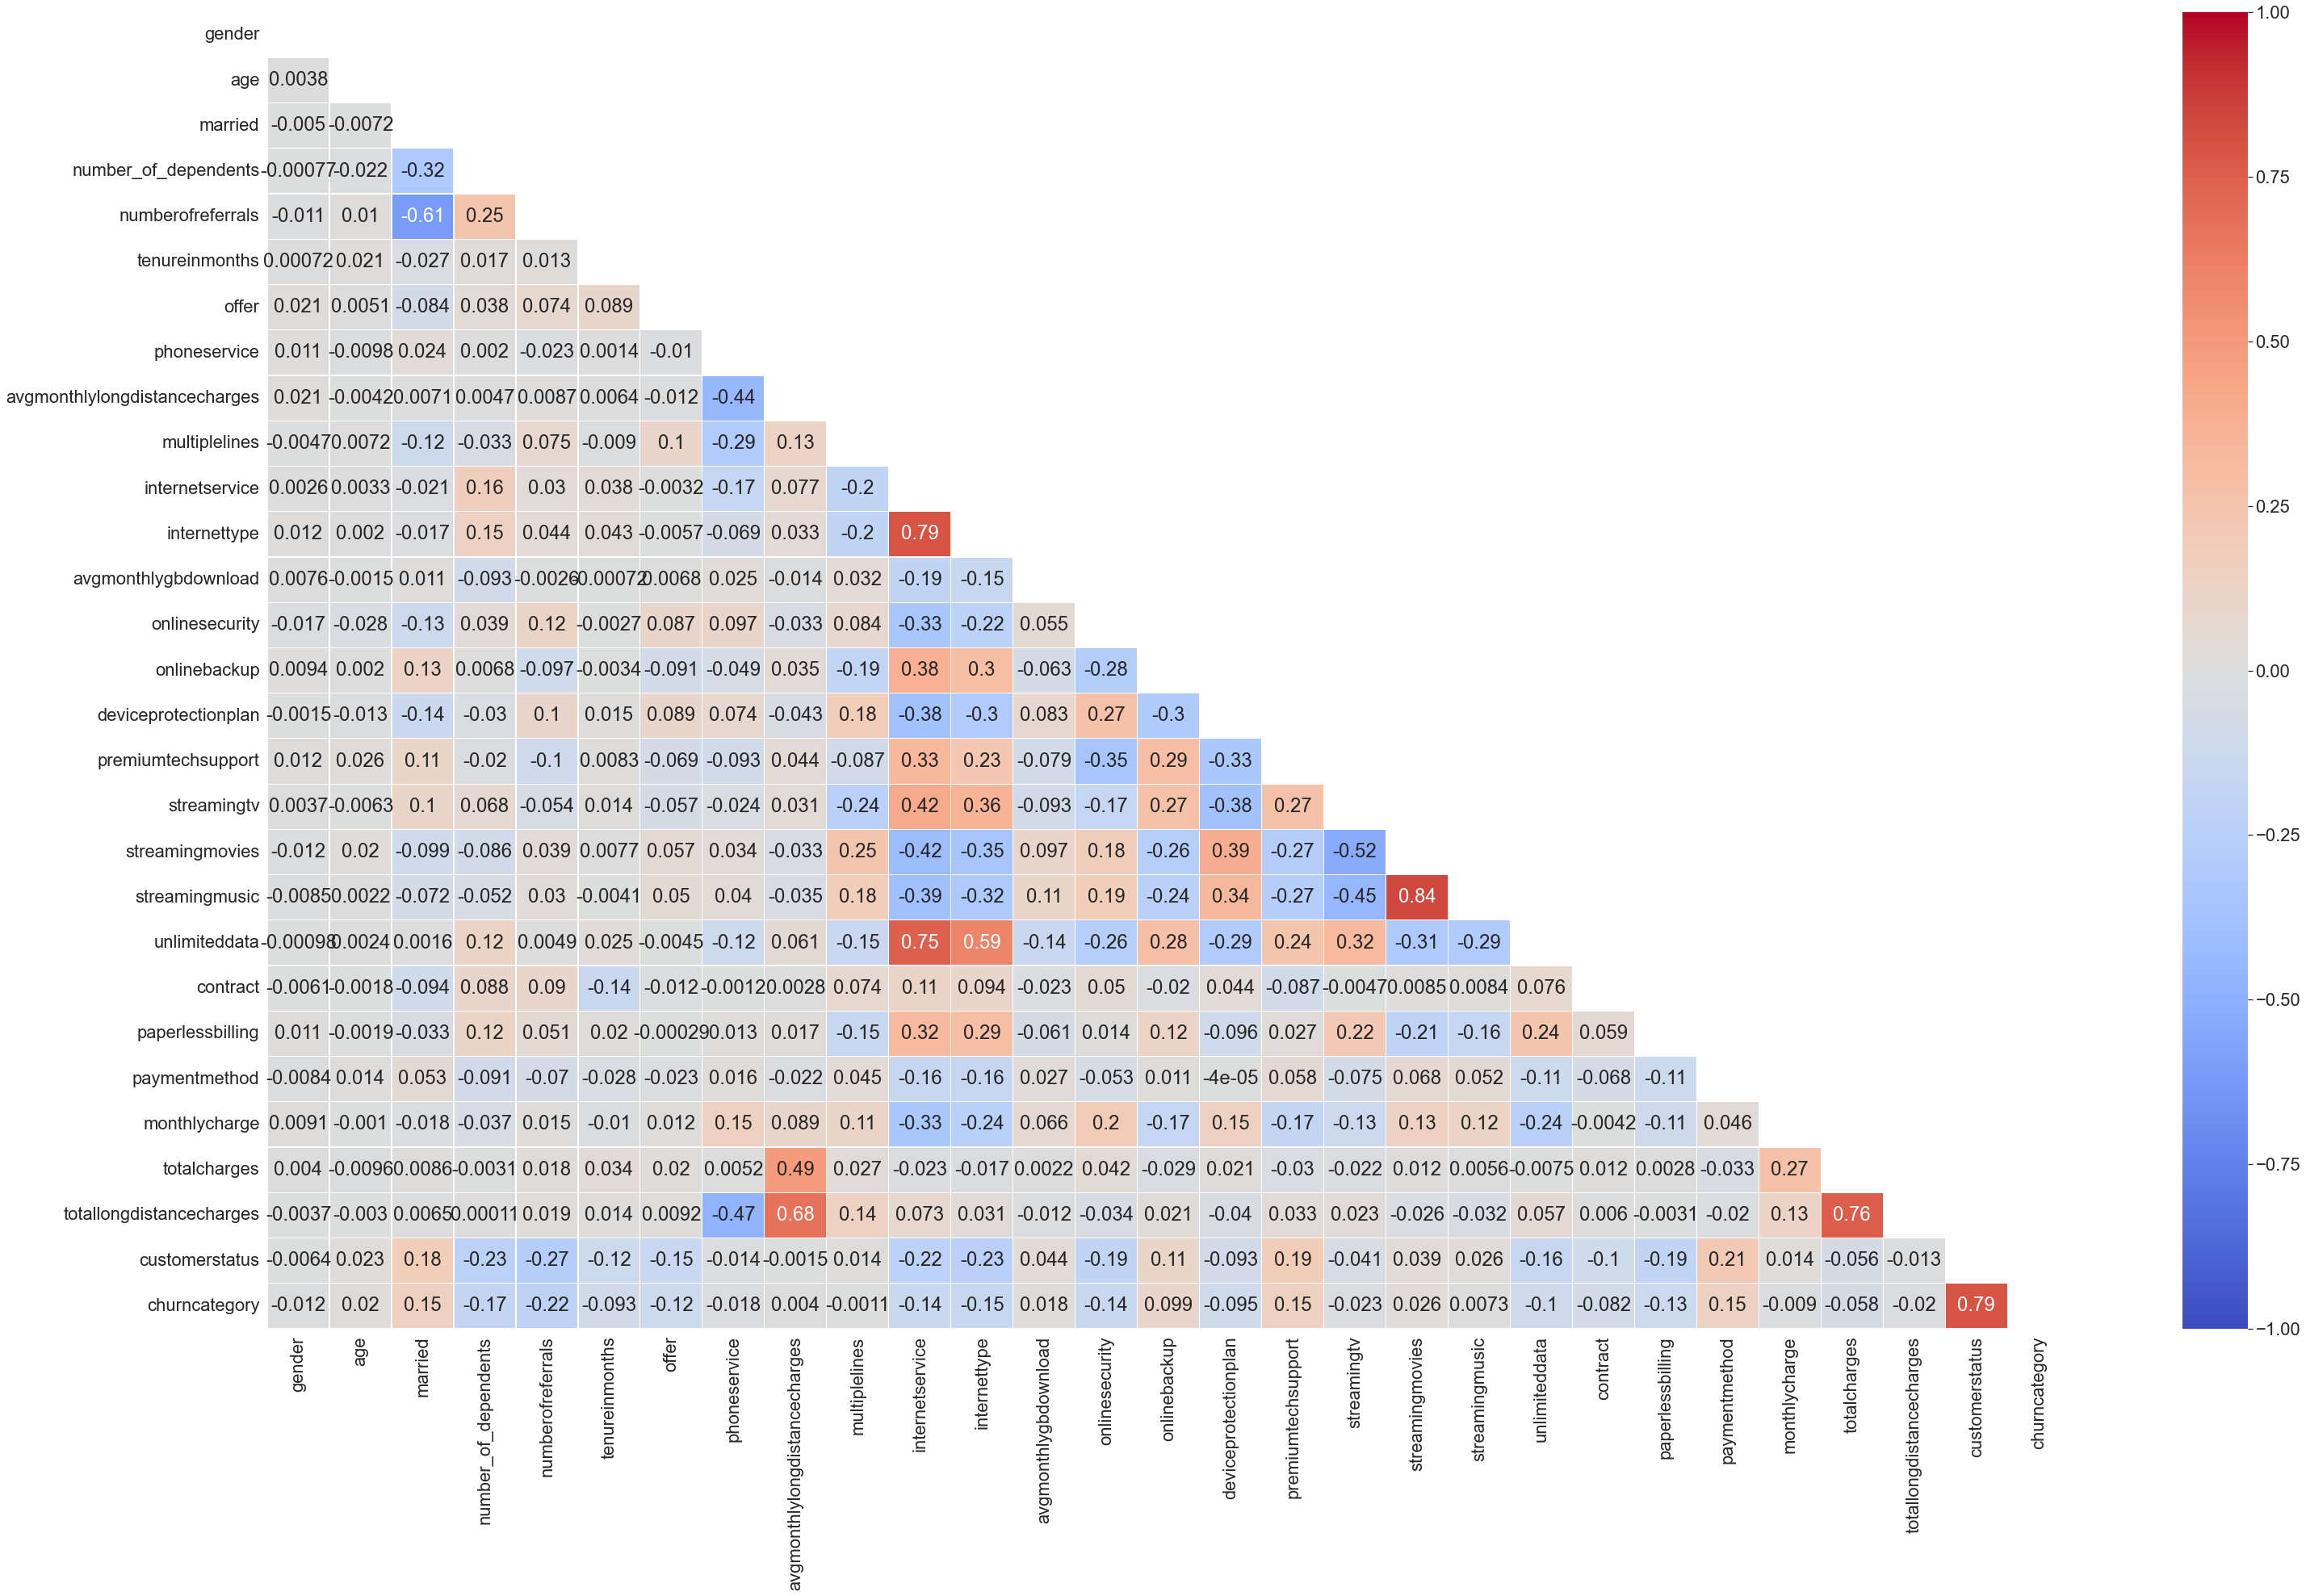

In [1109]:

# Correlation between all variables
plt.figure(50, figsize=(50, 30))
corr = preprocessing_df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

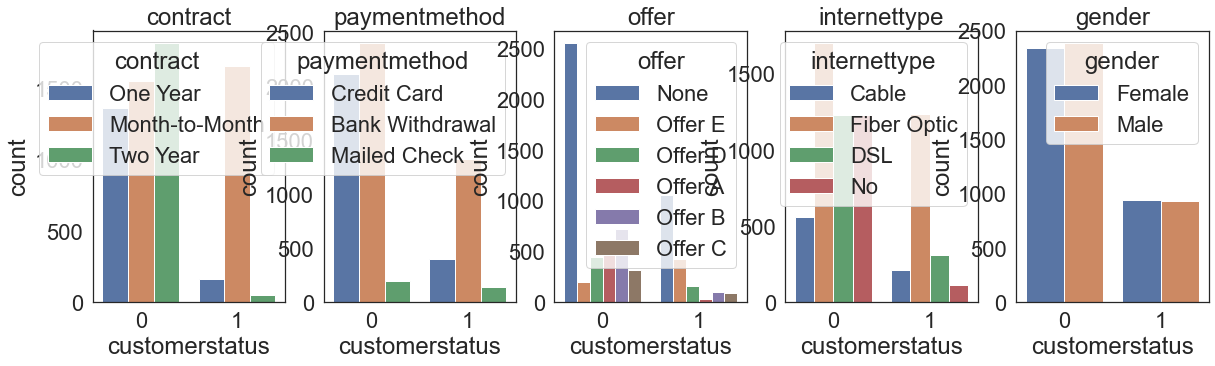

In [1110]:
## Correlation between churn and  object datatype
cols = ['contract',"paymentmethod","offer","internettype",'gender']

plt.figure(figsize=(20,5))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="customerstatus", hue = str(col), data = preprocessing_df)
    ax.set_title(f"{col}")


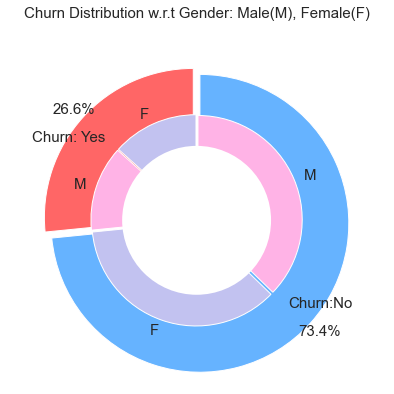

In [1111]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [1112]:
fig = px.histogram(preprocessing_df, x="customerstatus", color = "contract", barmode = "group", title = "<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.2)
fig.show()

In [1113]:
labels = preprocessing_df['paymentmethod'].unique()
values = preprocessing_df['paymentmethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

fig = px.histogram(preprocessing_df, x="customerstatus", color="paymentmethod", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [1114]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [965, 992, 219, 240],
  name = 'DSL',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [889, 910, 664, 633],
  name = 'Fiber optic',
))

fig.add_trace(go.Bar(
  x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],
       ["Female", "Male", "Female", "Male"]],
  y = [690, 717, 56, 57],
  name = 'No Internet',
))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")

fig.show()

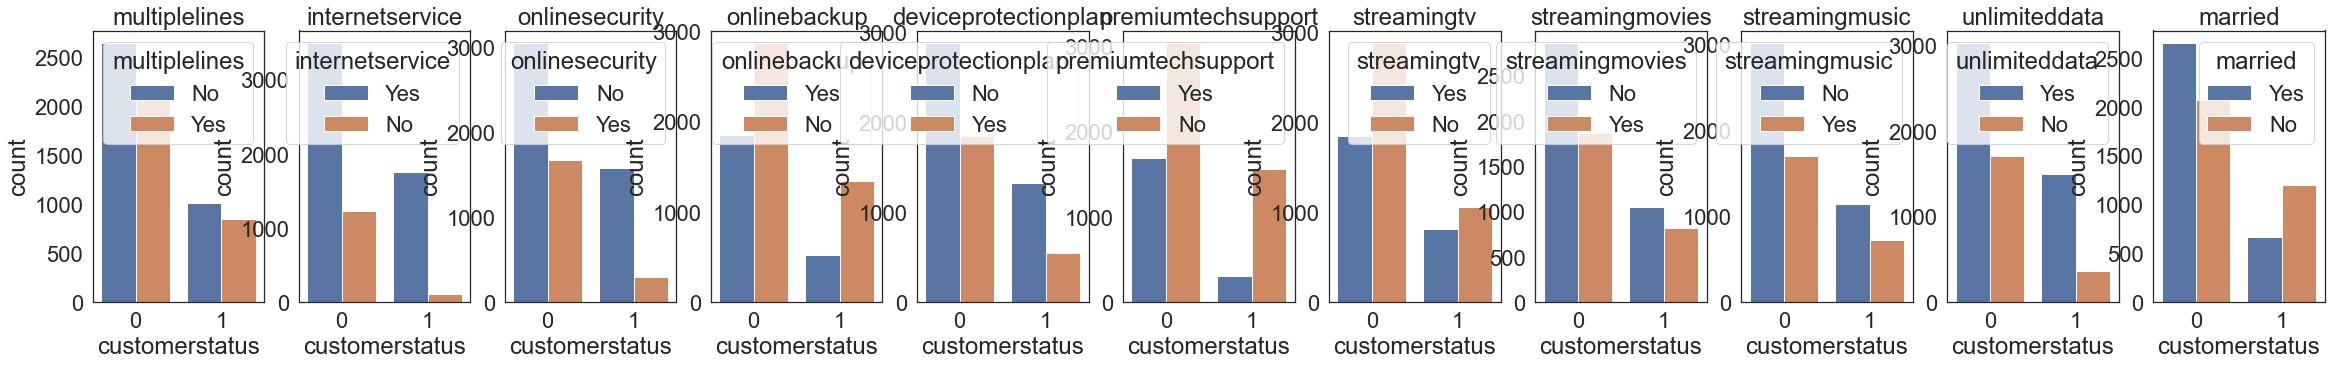

In [1115]:
# Correlation between churn and categorical data

cols = ['multiplelines', 'internetservice','onlinesecurity',
                'onlinebackup','deviceprotectionplan',
                'premiumtechsupport','streamingtv','streamingmovies','streamingmusic','unlimiteddata','married']


plt.figure(figsize=(40,5))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="customerstatus", hue = str(col), data = preprocessing_df)
    ax.set_title(f"{col}")

In [1116]:
preprocessing_df.internetservice.describe(include=["object", "bool"])

count     6589
unique       2
top        Yes
freq      5245
Name: internetservice, dtype: object

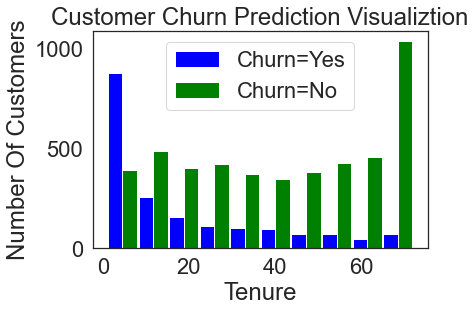

In [1117]:
tenurechurn_no = preprocessing_df[preprocessing_df['customerstatus']== 0]['tenureinmonths']
tenurechurn_yes = preprocessing_df[preprocessing_df['customerstatus']== 1]['tenureinmonths']

plt.xlabel("Tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([tenurechurn_yes, tenurechurn_no], rwidth=0.95, color=['blue','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

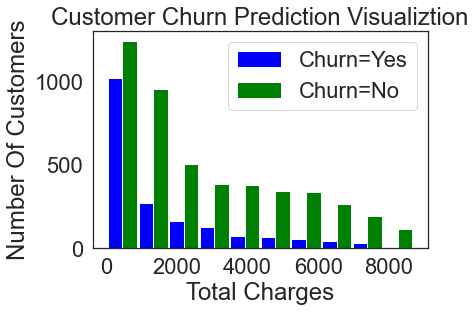

In [1118]:
totalchargeschurn_no = preprocessing_df[preprocessing_df['customerstatus']== 0]['totalcharges']
totalchargeschurn_yes = preprocessing_df[preprocessing_df['customerstatus']== 1]['totalcharges']

plt.xlabel("Total Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([totalchargeschurn_yes, totalchargeschurn_no], rwidth=0.95, color=['blue','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

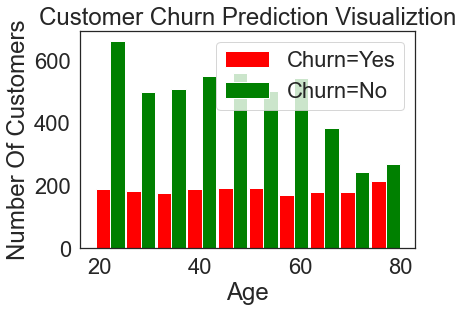

In [1119]:
agechurn_no = preprocessing_df[preprocessing_df['customerstatus']== 0]['age']
agechurn_yes = preprocessing_df[preprocessing_df['customerstatus']== 1]['age']

plt.xlabel("Age")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([agechurn_yes, agechurn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

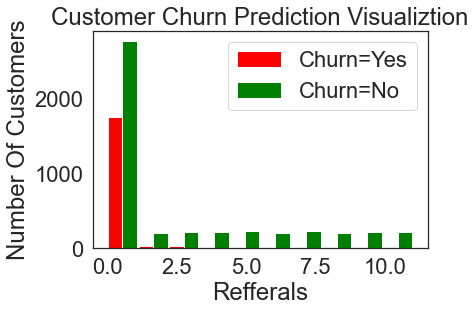

In [1120]:
refchurn_no = preprocessing_df[preprocessing_df['customerstatus']== 0]['numberofreferrals']
refchurn_yes = preprocessing_df[preprocessing_df['customerstatus']== 1]['numberofreferrals']

plt.xlabel("Refferals")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([refchurn_yes, refchurn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

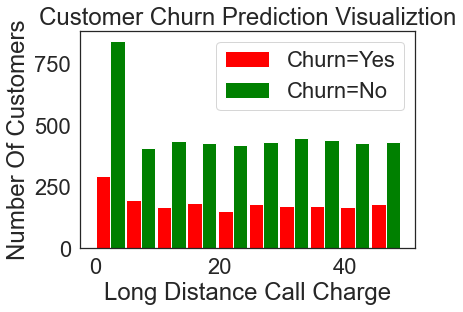

In [1121]:
preprocessing_df['avgmonthlylongdistancecharges'] = preprocessing_df['avgmonthlylongdistancecharges'].astype(int)
distchurn_no = preprocessing_df[preprocessing_df['customerstatus']== 0]['avgmonthlylongdistancecharges']
distchurn_yes = preprocessing_df[preprocessing_df['customerstatus']== 1]['avgmonthlylongdistancecharges']

plt.xlabel("Long Distance Call Charge")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([distchurn_yes, distchurn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

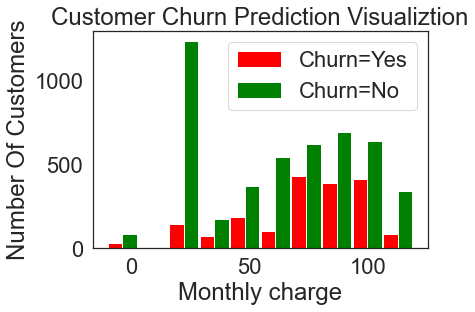

In [1122]:
monthchurn_no = preprocessing_df[preprocessing_df['customerstatus']== 0]['monthlycharge']
monthchurn_yes = preprocessing_df[preprocessing_df['customerstatus']== 1]['monthlycharge']

plt.xlabel("Monthly charge")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([monthchurn_yes, monthchurn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

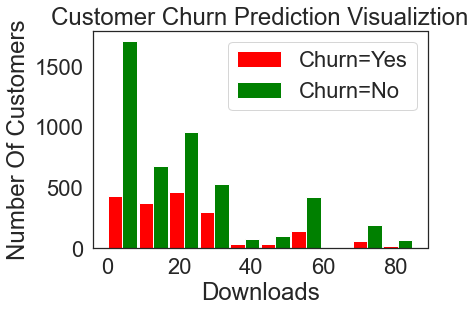

In [1123]:
preprocessing_df['avgmonthlygbdownload'] = preprocessing_df['avgmonthlygbdownload'].astype(int)
mdownchurn_no = preprocessing_df[preprocessing_df['customerstatus']== 0]['avgmonthlygbdownload']
mdownchurn_yes = preprocessing_df[preprocessing_df['customerstatus']== 1]['avgmonthlygbdownload']

plt.xlabel("Downloads")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([mdownchurn_yes, mdownchurn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

In [1124]:
preprocessing_df.columns

Index(['gender', 'age', 'married', 'number_of_dependents', 'numberofreferrals',
       'tenureinmonths', 'offer', 'phoneservice',
       'avgmonthlylongdistancecharges', 'multiplelines', 'internetservice',
       'internettype', 'avgmonthlygbdownload', 'onlinesecurity',
       'onlinebackup', 'deviceprotectionplan', 'premiumtechsupport',
       'streamingtv', 'streamingmovies', 'streamingmusic', 'unlimiteddata',
       'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharge',
       'totalcharges', 'totallongdistancecharges', 'customerstatus',
       'churncategory'],
      dtype='object')

Supervised Learning is applied when we have a labelled data set i.e., we already have our output variable/dependent variable.

1) Naive Bayes -- best applied to a data set containing multiple features (independent variable) and an output variable which takes two discrete value (Yes/No). Thus, categorical data.

2) SVM -- best applied to a data set containing infinite number of features and you need to reduce these features down to a number so that it can be computed. Since it's a classification algorithm so it best works upon categorical data. 

3) Regression -- Linear Regression is applied to a continuous numerical data set in which the dependent and independent variable exhibits linear relationship. For example, size of the house vs house price. Logistic Regression is a classification algorithm so it is best applied to categorical data. 3) K-Means -- K-Means can applied to many types of data sets. What it does is segmenting data points into clusters. Data points with similar features are clustered together.

4) Neural Networks -- Neural Networks can be shallow neural networks and deep neural networks and both of these could be applied to supervised or unsupervised problem as it has separate algorithms for both the cases. It is the most powerful and popular class of ML algorithms. It can be used in every problem statement. Main intuition behind it learning from its own error. I do not have much knowledge about neural network so I will not write further more.

In [1125]:
for col in preprocessing_df:
    print(f'{col}: {preprocessing_df[col].unique()}') 

gender: ['Female' 'Male']
age: [37 46 50 78 75 23 67 52 68 43 47 25 58 32 39 79 26 30 34 42 64 48 28 33
 31 60 69 20 57 19 38 35 72 51 66 36 61 24 55 59 71 49 40 21 45 29 62 76
 77 73 41 56 54 22 80 63 53 44 70 74 27 65]
married: ['Yes' 'No']
number_of_dependents: [0 3 1 2 4 6 5 9 7 8]
numberofreferrals: [ 2  0  1  3  8  9 10  5  4  7  6 11]
tenureinmonths: [ 9  4 13  3 71 63  7 65 54 72  5 56 34 45  1 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 16 58 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
offer: ['None' 'Offer E' 'Offer D' 'Offer A' 'Offer B' 'Offer C']
phoneservice: ['Yes' 'No']
avgmonthlylongdistancecharges: [42 10 33 27  7 16  9 12 28  0 18  2 31 43 34 35 19 37 38 49 23 30  5 25
 48  6 32 24 36 44 11 20 39  8 40 47 45 14  1 13 41 46 22  3 15 17  4 21
 26 29]
multiplelines: ['No' 'Yes']
internetservice: ['Yes' 'No']
internettype: ['Cable' 'Fiber Optic' 'DSL' 'No']
avgmonthlygbdownload: [16 10 30  4 

In [1126]:


def encode_data(df):
    if df.dtype == "object":
        df = LabelEncoder().fit_transform(df)
    return df

processed_df = preprocessing_df.copy
processed_df = preprocessing_df.apply(lambda x: encode_data(x))
processed_df.head()

gender  age  married  number_of_dependents  numberofreferrals  \
0       0   37        1                     0                  2   
1       1   46        0                     0                  0   
2       1   50        0                     0                  0   
3       1   78        1                     0                  1   
4       0   75        1                     0                  3   

   tenureinmonths  offer  phoneservice  avgmonthlylongdistancecharges  \
0               9      0             1                             42   
1               9      0             1                             10   
2               4      5             1                             33   
3              13      4             1                             27   
4               3      0             1                              7   

   multiplelines  ...  streamingmusic  unlimiteddata  contract  \
0              0  ...               0              1         1   
1              1  ...               1              0         0   
2              0  ...               0              1         0   
3              0  ...               0              1         0   
4              0  ...               0              1         0   

   paperlessbilling  paymentmethod  monthlycharge  totalcharges  \
0                 1              1           65.6        593.30   
1                 0              1           -4.0        542.40   
2                 1              0           73.9        280.85   
3                 1              0           98.0       1237.85   
4                 1              1           83.9        267.40   

   totallongdistancecharges  customerstatus  churncategory  
0                    381.51               0              5  
1                     96.21               0              5  
2                    134.60               1              1  
3                    361.66               1              2  
4                     22.14               1              2  

[5 rows x 29 columns]

DATA PREPARATION FULFILLING THE BASIC ASSUMPTIONS OF MACHINE LEARNING MODELS AND PREDICTED OUTCOME

Prediction Outcome Nature - Binary outcome
Predicting whether the customer will churn or not
The basic assumptions for different machine learning models selected  based on the prediction outcome

1. Logistic regression

- a. The Response Variable is Binary
- b. There is No Multicollinearity Among Explanatory Variables [We have done variance inflation factor  check and removed the variables that exhibit high collinearity]
- c. The Sample Size is Sufficiently Large (more than 500 data points)
- d.There are No Extreme Outliers (our data exploration box plots have shown no extreme outliers in the explantory or responsive variables)


1. Decision trees assume that the different predictors are independent and combine together to form a an overall likelihood of one class over another. 

In [1127]:
#--------------------#
# MULTICOLLINEARITY  #
#--------------------#
#VIF starts at 1, and if the 10 value is exceeded, that will indicate high multicollinearity between the independent variables.

def calculate_vif(X):
# Calculating Variable Inflation Factors
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["Variable Inflation Factors"] = [variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])]
    return(vif)

ds_vif = processed_df[['internetservice','totallongdistancecharges','paperlessbilling','gender','totalcharges','monthlycharge','number_of_dependents','multiplelines','onlinesecurity','onlinebackup','deviceprotectionplan','avgmonthlygbdownload','avgmonthlylongdistancecharges','age','premiumtechsupport','streamingtv','streamingmovies','streamingmusic','unlimiteddata','married','tenureinmonths', 'phoneservice','numberofreferrals','offer','contract','paymentmethod','internettype']]

vif = calculate_vif(ds_vif)
vif

variables  Variable Inflation Factors
0                 internetservice                   33.349886
1        totallongdistancecharges                   10.143298
2                paperlessbilling                    3.008385
3                          gender                    1.998072
4                    totalcharges                   18.010224
5                   monthlycharge                   38.077268
6            number_of_dependents                    1.535606
7                   multiplelines                    2.666953
8                  onlinesecurity                    2.054172
9                    onlinebackup                    2.300010
10           deviceprotectionplan                    2.417212
11           avgmonthlygbdownload                    4.017504
12  avgmonthlylongdistancecharges                   10.741465
13                            age                   13.107390
14             premiumtechsupport                    2.113602
15                    streamingtv                    3.068051
16                streamingmovies                    8.366706
17                 streamingmusic                    6.754751
18                  unlimiteddata                    7.271468
19                        married                    3.938603
20                 tenureinmonths                   19.578517
21                   phoneservice                   17.418270
22              numberofreferrals                    2.686470
23                          offer                    1.757510
24                       contract                    3.943976
25                  paymentmethod                    1.802167
26                   internettype                   10.367536

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

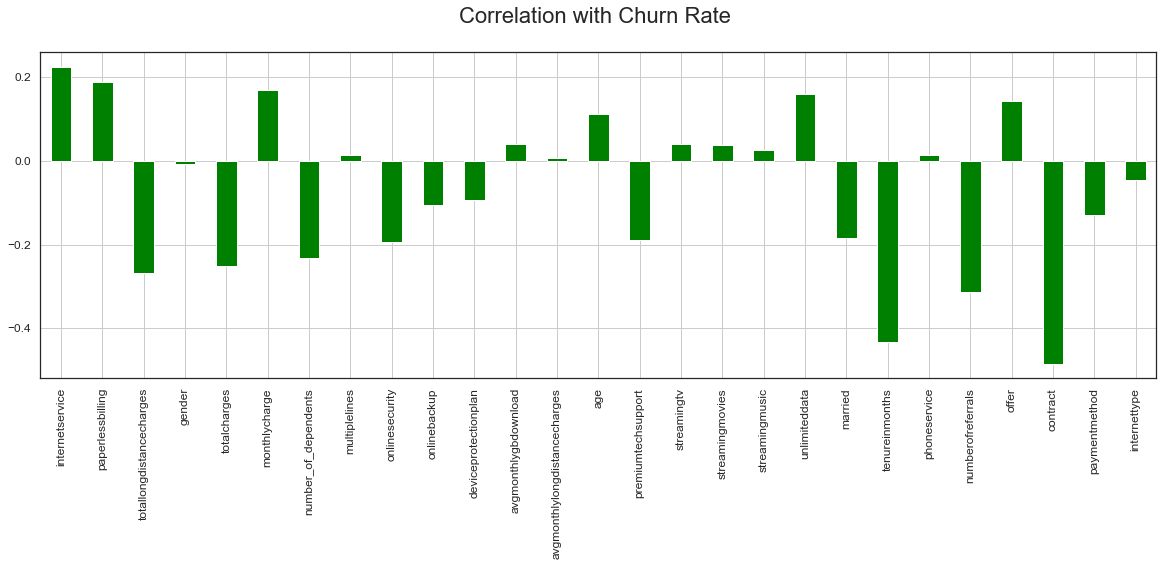

In [1128]:
# Correlation between churn and selected boolean and numeric variables
plt.figure(6)
ds_corr = processed_df[['internetservice','paperlessbilling','totallongdistancecharges','gender','totalcharges','monthlycharge','number_of_dependents','multiplelines','onlinesecurity','onlinebackup','deviceprotectionplan','avgmonthlygbdownload','avgmonthlylongdistancecharges','age','premiumtechsupport','streamingtv','streamingmovies','streamingmusic','unlimiteddata','married','tenureinmonths', 'phoneservice','numberofreferrals','offer','contract','paymentmethod','internettype']]

correlations = ds_corr.corrwith(processed_df['customerstatus'])
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (20, 6),
        fontsize = 12,
        color = 'green',
        rot = 90, grid = True)

plt.title('Correlation with Churn Rate \n', horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

Text(0.5, 1.0, 'Correlation with Monthly Rate \n')

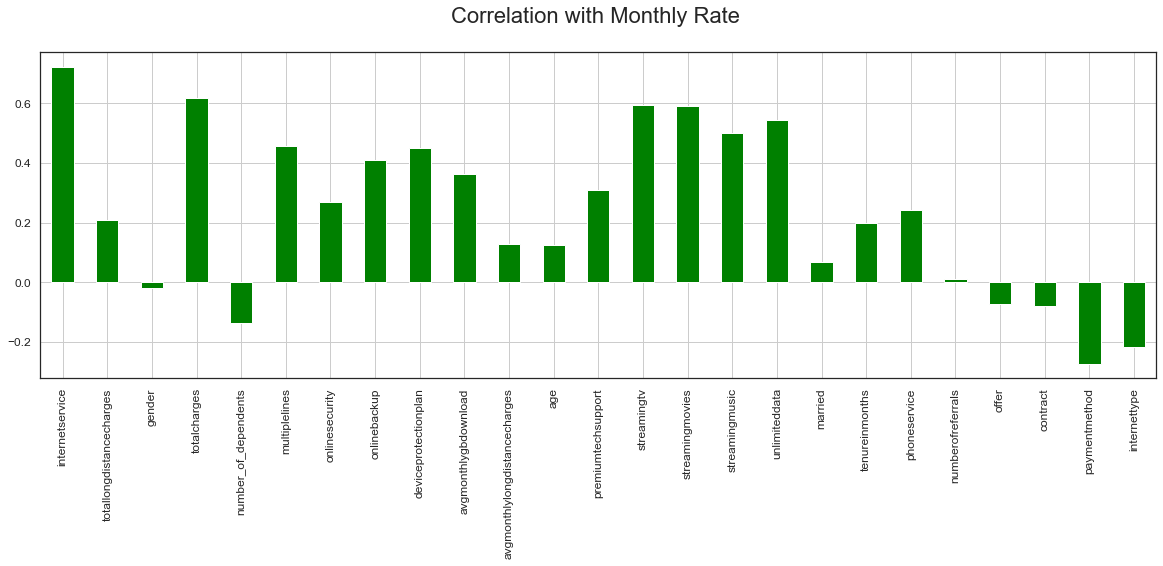

In [1129]:
plt.figure(6)
ds_corr = processed_df[['internetservice','totallongdistancecharges','gender','totalcharges','number_of_dependents','multiplelines','onlinesecurity','onlinebackup','deviceprotectionplan','avgmonthlygbdownload','avgmonthlylongdistancecharges','age','premiumtechsupport','streamingtv','streamingmovies','streamingmusic','unlimiteddata','married','tenureinmonths', 'phoneservice','numberofreferrals','offer','contract','paymentmethod','internettype']]

correlations = ds_corr.corrwith(processed_df['monthlycharge'])
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (20, 6),
        fontsize = 12,
        color = 'green',
        rot = 90, grid = True)

plt.title('Correlation with Monthly Rate \n', horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

In [1130]:
# we will drop 'TotalCharges'&'Total Long Distance Charges' from VIF test dataset.
#Here we are only considering the continuous variable and not the categorical data.
# categorical variables have a greater tendency to generate collinearity is that the three-way or four-way tabulations often form linear combinations that lead to complete collinearity
ds_vif2 = ds_vif.drop(columns = ["totalcharges","phoneservice","totallongdistancecharges","internetservice","streamingtv","streamingmovies","streamingmusic","unlimiteddata","multiplelines","deviceprotectionplan", 'premiumtechsupport','paperlessbilling','onlinesecurity',"onlinebackup",'married','gender'])

# check colinearity again
vif2 = calculate_vif(ds_vif2)
vif2

variables  Variable Inflation Factors
0                   monthlycharge                    8.144213
1            number_of_dependents                    1.453979
2            avgmonthlygbdownload                    2.792151
3   avgmonthlylongdistancecharges                    3.286866
4                             age                    6.598399
5                  tenureinmonths                    6.215473
6               numberofreferrals                    1.743405
7                           offer                    1.693192
8                        contract                    3.520135
9                   paymentmethod                    1.683101
10                   internettype                    4.343061

In [1131]:
processed_df.columns

Index(['gender', 'age', 'married', 'number_of_dependents', 'numberofreferrals',
       'tenureinmonths', 'offer', 'phoneservice',
       'avgmonthlylongdistancecharges', 'multiplelines', 'internetservice',
       'internettype', 'avgmonthlygbdownload', 'onlinesecurity',
       'onlinebackup', 'deviceprotectionplan', 'premiumtechsupport',
       'streamingtv', 'streamingmovies', 'streamingmusic', 'unlimiteddata',
       'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharge',
       'totalcharges', 'totallongdistancecharges', 'customerstatus',
       'churncategory'],
      dtype='object')

In [1132]:
cols_to_scale = ['totallongdistancecharges','tenureinmonths','monthlycharge','totalcharges','avgmonthlygbdownload',
                 'avgmonthlylongdistancecharges','age','numberofreferrals','offer','contract','churncategory']

scaler = MinMaxScaler()
processed_df[cols_to_scale] = scaler.fit_transform(processed_df[cols_to_scale])
processed_df

gender       age  married  number_of_dependents  numberofreferrals  \
0          0  0.295082        1                     0           0.181818   
1          1  0.442623        0                     0           0.000000   
2          1  0.508197        0                     0           0.000000   
3          1  0.967213        1                     0           0.090909   
4          0  0.918033        1                     0           0.272727   
...      ...       ...      ...                   ...                ...   
7037       0  0.278689        0                     0           0.000000   
7038       0  0.016393        0                     0           0.000000   
7039       1  0.344262        1                     0           0.090909   
7041       1  0.032787        1                     0           0.454545   
7042       1  0.278689        1                     0           0.090909   

      tenureinmonths  offer  phoneservice  avgmonthlylongdistancecharges  \
0           0.112676    0.0             1                       0.857143   
1           0.112676    0.0             1                       0.204082   
2           0.042254    1.0             1                       0.673469   
3           0.169014    0.8             1                       0.551020   
4           0.028169    0.0             1                       0.142857   
...              ...    ...           ...                            ...   
7037        0.042254    0.0             1                       0.040816   
7038        0.169014    0.8             1                       0.938776   
7039        0.295775    0.8             1                       0.326531   
7041        0.929577    0.2             1                       0.040816   
7042        0.873239    0.0             0                       0.000000   

      multiplelines  ...  streamingmusic  unlimiteddata  contract  \
0                 0  ...               0              1       0.5   
1                 1  ...               1              0       0.0   
2                 0  ...               0              1       0.0   
3                 0  ...               0              1       0.0   
4                 0  ...               0              1       0.0   
...             ...  ...             ...            ...       ...   
7037              0  ...               0              0       0.0   
7038              0  ...               1              1       0.5   
7039              1  ...               1              1       0.0   
7041              0  ...               1              1       1.0   
7042              0  ...               1              1       1.0   

      paperlessbilling  paymentmethod  monthlycharge  totalcharges  \
0                    1              1       0.587184      0.066288   
1                    0              1       0.046602      0.060415   
2                    1              0       0.651650      0.030233   
3                    1              0       0.838835      0.140665   
4                    1              1       0.729320      0.028681   
...                ...            ...            ...           ...   
7037                 0              0       0.240388      0.007691   
7038                 0              1       0.506019      0.083551   
7039                 1              0       0.738641      0.214039   
7041                 0              1       0.604660      0.531829   
7042                 0              0       0.535922      0.425660   

      totallongdistancecharges  customerstatus  churncategory  
0                     0.107024               0            1.0  
1                     0.026989               0            1.0  
2                     0.037759               1            0.2  
3                     0.101455               1            0.4  
4                     0.006211               1            0.4  
...                        ...             ...            ...  
7037                  0.002255               1            0.2 

In [1133]:
for col in processed_df:
    print(f'{col}: {processed_df[col].unique()}')

gender: [0 1]
age: [0.29508197 0.44262295 0.50819672 0.96721311 0.91803279 0.06557377
 0.78688525 0.54098361 0.80327869 0.39344262 0.45901639 0.09836066
 0.63934426 0.21311475 0.32786885 0.98360656 0.1147541  0.18032787
 0.24590164 0.37704918 0.73770492 0.47540984 0.14754098 0.2295082
 0.19672131 0.67213115 0.81967213 0.01639344 0.62295082 0.
 0.31147541 0.26229508 0.86885246 0.52459016 0.7704918  0.27868852
 0.68852459 0.08196721 0.59016393 0.6557377  0.85245902 0.49180328
 0.3442623  0.03278689 0.42622951 0.16393443 0.70491803 0.93442623
 0.95081967 0.8852459  0.36065574 0.60655738 0.57377049 0.04918033
 1.         0.72131148 0.55737705 0.40983607 0.83606557 0.90163934
 0.13114754 0.75409836]
married: [1 0]
number_of_dependents: [0 3 1 2 4 6 5 9 7 8]
numberofreferrals: [0.18181818 0.         0.09090909 0.27272727 0.72727273 0.81818182
 0.90909091 0.45454545 0.36363636 0.63636364 0.54545455 1.        ]
tenureinmonths: [0.11267606 0.04225352 0.16901408 0.02816901 0.98591549 0.87323944


In [1134]:
processed_df.columns

Index(['gender', 'age', 'married', 'number_of_dependents', 'numberofreferrals',
       'tenureinmonths', 'offer', 'phoneservice',
       'avgmonthlylongdistancecharges', 'multiplelines', 'internetservice',
       'internettype', 'avgmonthlygbdownload', 'onlinesecurity',
       'onlinebackup', 'deviceprotectionplan', 'premiumtechsupport',
       'streamingtv', 'streamingmovies', 'streamingmusic', 'unlimiteddata',
       'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharge',
       'totalcharges', 'totallongdistancecharges', 'customerstatus',
       'churncategory'],
      dtype='object')

In [1135]:
#LIST OF COLUMNS THAT WILL BE USED TO COMPARE THE MODELS

list_of_columns = ['age','married','unlimiteddata','numberofreferrals','offer','onlinesecurity','premiumtechsupport','tenureinmonths',
                    'contract','number_of_dependents','customerstatus','paperlessbilling','monthlycharge']


                

In [1136]:
model_df = processed_df[list_of_columns]

In [1137]:
X = model_df.drop('customerstatus',axis='columns')
y = model_df['customerstatus']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)
X_train.shape

(5271, 12)

A fit refers to how well you approximate a target function.A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.The main intuitive difference between the L1 and L2 regularization is that L1 regularization tries to estimate the median of the data while the L2 regularization tries to estimate the mean of the data to avoid overfitting.

## MODELS

In [1138]:
#Machine Learning Models selection for Telecom Churn Data Prediction
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0, class_weight='balanced')))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 0)))
models.append(("Adaboost", AdaBoostClassifier()))


In [1139]:
#Measuring selected algorithms for ROC AUC Mean, ROC AUC STD, Accuracy Mean and Accuracy STD 
#This output is required to determine which algorithm best fit for the churn prediction
acc_results =[]
auc_results =[]
names = []

result_col = ["Algorithm", "ROC AUC Mean", "ROC AUC STD", "Accuracy Mean", "Accuracy STD"]
model_results = pd.DataFrame(columns = result_col)

i=0
# K- fold cross validation

for name, model in models:
    names.append(name)
    kfold = model_selection.KFold(n_splits=10, random_state=None)
    
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring="accuracy")
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring="roc_auc")
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    
    model_results.loc[i] = [name, 
                           round(cv_auc_results.mean()*100,2),
                           round(cv_auc_results.std()*100,2),
                           round(cv_acc_results.mean()*100,2),
                           round(cv_acc_results.std()*100,2)]
    i+=1



model_results.sort_values(by = ['ROC AUC Mean'], ascending=False)

Algorithm  ROC AUC Mean  ROC AUC STD  Accuracy Mean  \
4                  Adaboost         92.83         1.05          86.63   
3             Random Forest         92.48         1.13          86.45   
0       Logistic Regression         90.07         0.99          80.23   
1                       KNN         85.61         1.72          82.13   
2  Decision Tree Classifier         78.84         2.05          82.62   

   Accuracy STD  
4          1.25  
3          1.77  
0          1.96  
1          1.25  
2          1.63

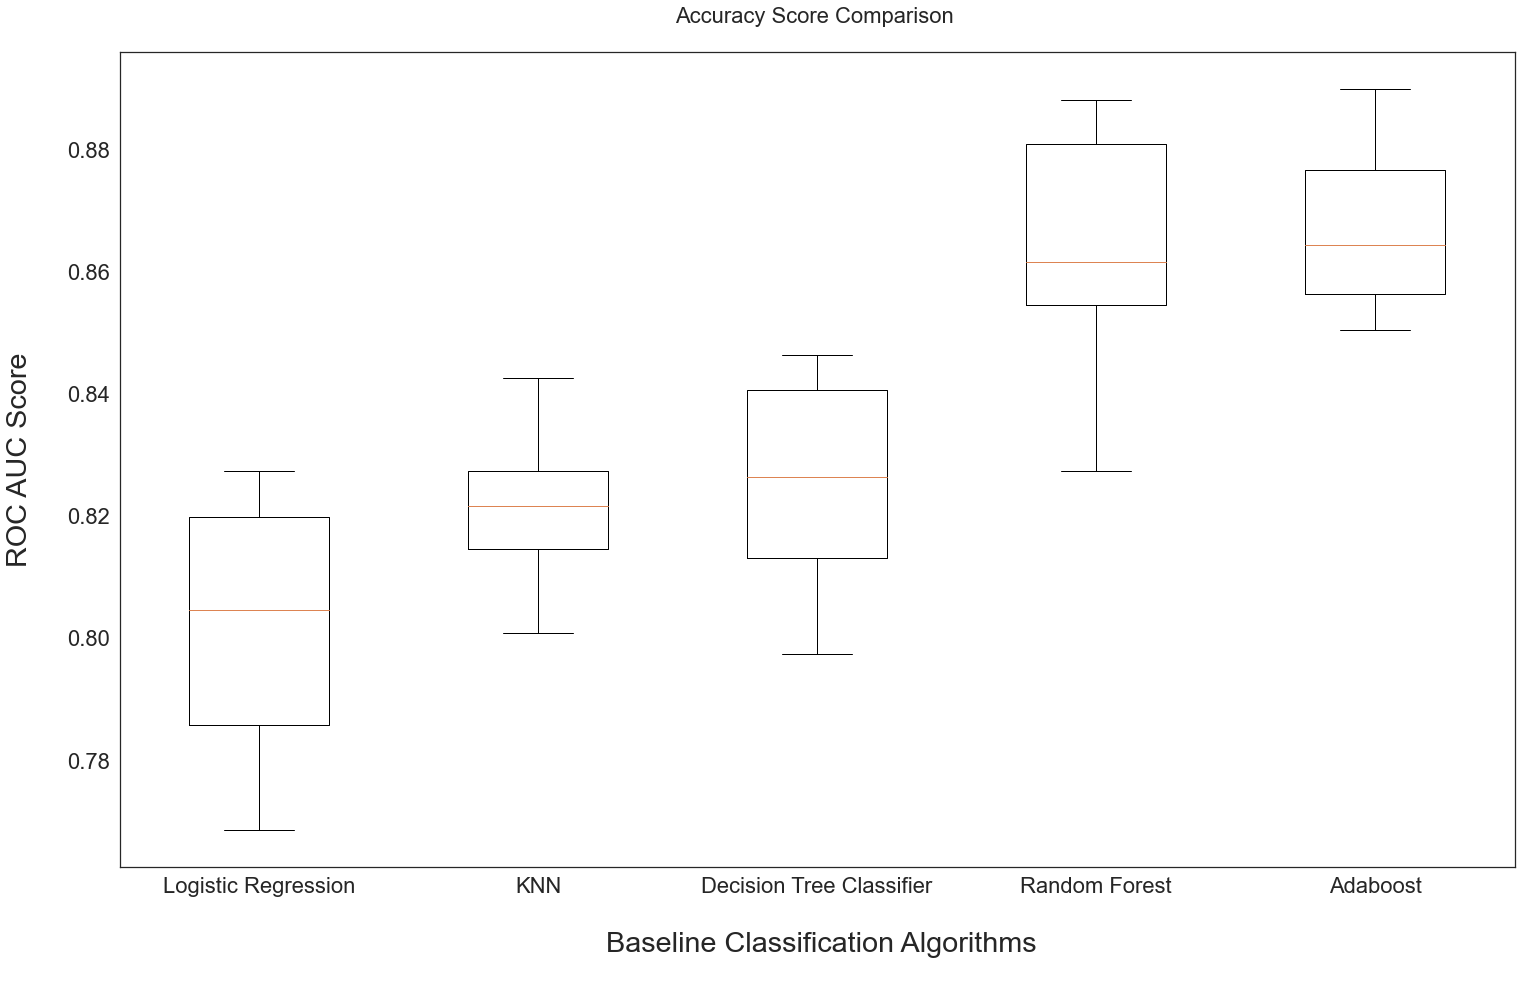

In [1140]:
#Plotting Accuracy Score comparision among machine learing models
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)

# ROC AUC Mean taking as ROC AUC Score
plt.ylabel('ROC AUC Score\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")

plt.xlabel('\n Baseline Classification Algorithms\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")

plt.title('Accuracy Score Comparison \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

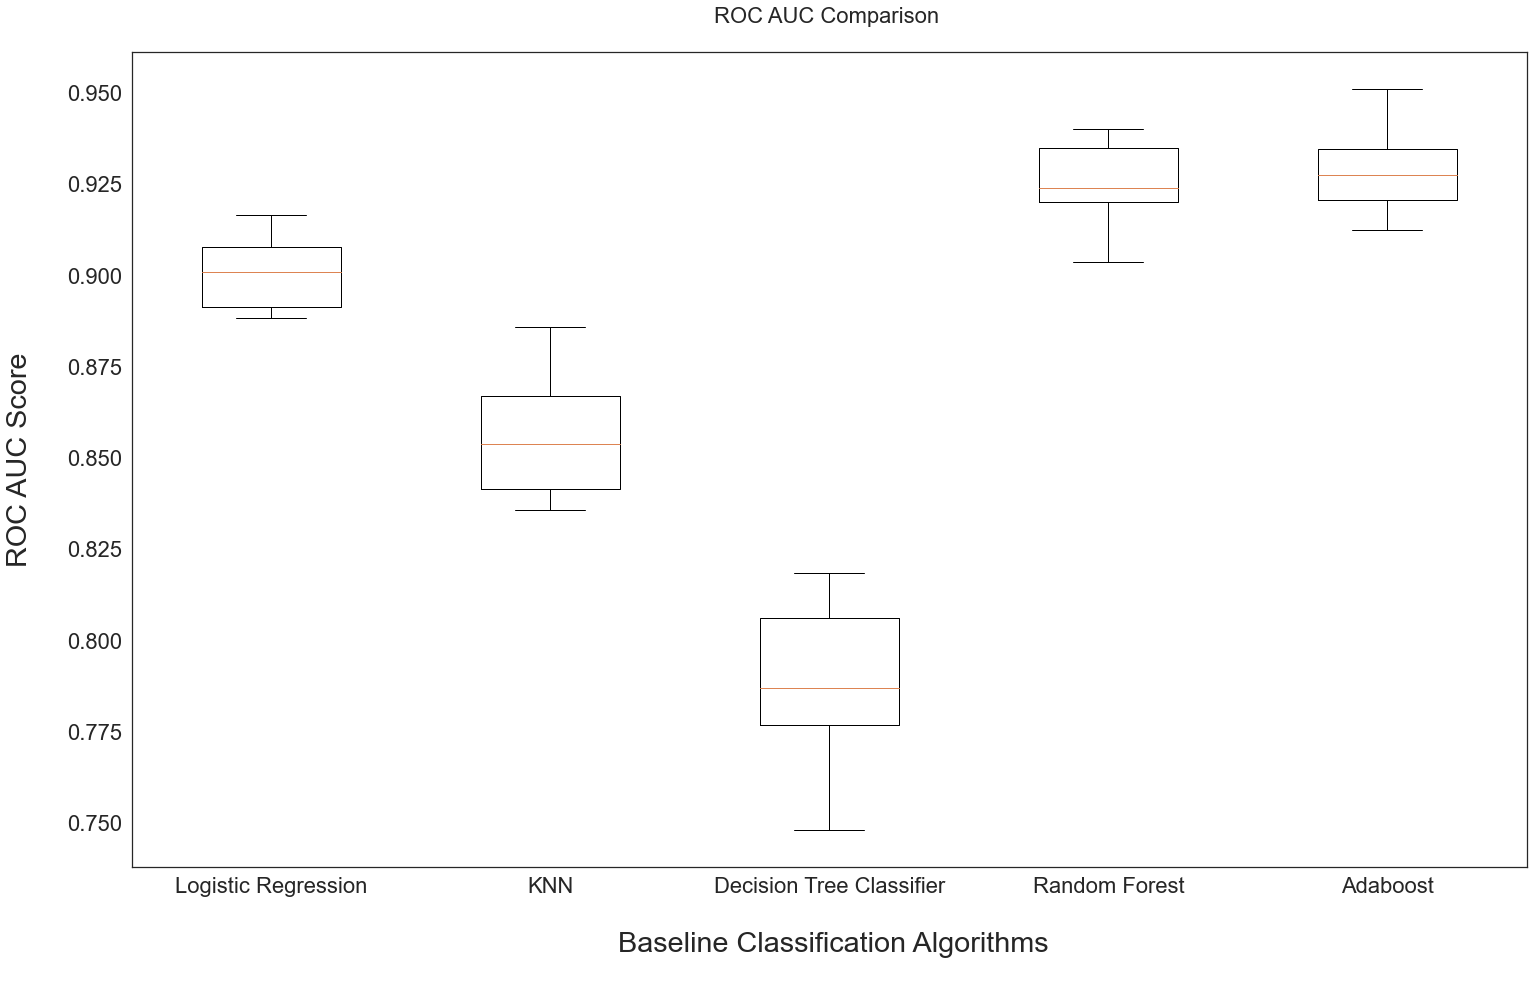

In [1141]:
#Plotting ROC AUC comparision among machine learing models
fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)

plt.ylabel('ROC AUC Score\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")

plt.xlabel('\n Baseline Classification Algorithms\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")

plt.title('ROC AUC Comparison \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

### Standard logistic regression

In [1142]:
# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

lr_l2.score(X_test, y_test)

0.8528072837632777

In [1143]:
y_pred =list()
y_prob =list()
coeff_labels = ['lr','l1','l2']
coeff_models = [lr, lr_l1,lr_l2]

for lab, mod in zip(coeff_labels,coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test),name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1),name=lab))
    
y_pred= pd.concat(y_pred, axis=1)
y_prob=pd.concat(y_prob, axis=1)

y_pred.apply(pd.Series.value_counts)

lr   l1   l2
0  927  928  930
1  391  390  388

In [1144]:
metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
                        label_binarize(y_pred[lab], classes=[0,1]), average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

model_metrics = pd.concat(metrics, axis=1)
model_metrics

lr        l1        l2
precision  0.856710  0.855823  0.854051
recall     0.855083  0.854325  0.852807
fscore     0.855804  0.854995  0.853375
accuracy   0.855083  0.854325  0.852807
auc        0.828020  0.826697  0.824052

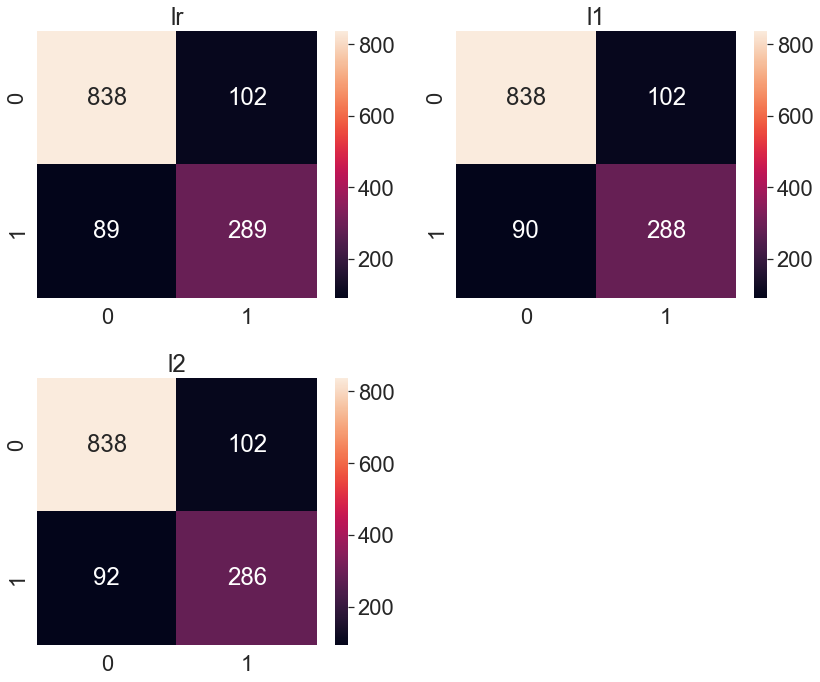

In [1145]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)
axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    sns.set(font_scale=2);
    
plt.tight_layout()

In [1146]:
# # Hyperparameter Tuning by Creating the GridSearchCV model 


model_comparison = pd.DataFrame(columns=['Model','Accuracy','Execution time'])

t0 = time.time()
accuracy_logistic_model = lr_l2.score(X_test, y_test)
t1 = time.time()

model_log = LogisticRegression()
param_grid = {'C': np.logspace(-3,3,7),
              'solver'  : ['liblinear'],
              'penalty' : ['l2'],
             'max_iter':[1000],}

grid = GridSearchCV(model_log, param_grid, verbose=3)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

model_comparison = model_comparison.append(
    {'Model': 'Logistic Model',
     'Accuracy': accuracy_logistic_model,
     'Execution time': '%0.8f seconds' % (t1 - t0)}, ignore_index = True)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear;, score=0.717 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear;, score=0.717 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear;, score=0.717 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear;, score=0.717 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, solver=liblinear;, score=0.717 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear;, score=0.834 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear;, score=0.814 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear;, score=0.828 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=1000, penalty=l2, solver=liblinear;, score=0.826 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=1000, penalty=l2, solve

## Decision tree machine learning

Introduction Decision Trees are a type of Supervised Machine Learning (that is you explain what the input is and what the corresponding output is in the training data) where the data is continuously split according to a certain parameter. The tree can be explained by two entities, namely decision nodes and leaves.



-----------------------------------------------------------
Accuracy of Decision Tree:  0.8270106221547799
Execution time: 0.01798844 seconds
-----------------------------------------------------------


<Figure size 432x288 with 0 Axes>

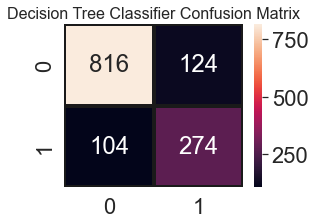

In [1147]:
decision_tree_model = DecisionTreeClassifier()

t0 = time.time()
decision_tree_model.fit(X_train,y_train)
t1 = time.time()
 
accuracy_decision_tree = decision_tree_model.score(X_test, y_test)
print("\n\n-----------------------------------------------------------")
print("Accuracy of Decision Tree: ", accuracy_decision_tree)
print("Execution time: %0.8f seconds" % (t1 - t0))
print("-----------------------------------------------------------")

# Decision Tree Classifier gives very low accuracy score.

decision_tree_prediction = decision_tree_model.predict(X_test)

plt.figure(11)
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, decision_tree_prediction),
                annot=True, fmt="d", linecolor="k", linewidths=3)

plt.title("Decision Tree Classifier Confusion Matrix", fontsize=16)
plt.show()

model_comparison = model_comparison.append(
    {'Model': 'Decision Tree Classifier',
     'Accuracy': accuracy_decision_tree,
     'Execution time': '%0.8f seconds' % (t1 - t0)}, ignore_index = True)

## RANDOM FOREST

Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression. Ensemble learning method is a technique that combines predictions from multiple machine learning algorithms to make a more accurate prediction than a single model.



-----------------------------------------------------------
Accuracy of Random Forest:  0.8823975720789075
Execution time: 2.43604422 seconds
-----------------------------------------------------------


<Figure size 432x288 with 0 Axes>

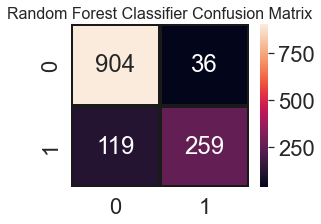

In [1148]:

random_forest_model = RandomForestClassifier(n_estimators=500,
                                  oob_score = True, n_jobs = -1,
                                  random_state=42, max_features = "auto",
                                  max_leaf_nodes = 30)

t0 = time.time()
random_forest_model.fit(X_train, y_train)
t1 = time.time()

accuracy_random_forest = random_forest_model.score(X_test, y_test)

print("\n\n-----------------------------------------------------------")
print("Accuracy of Random Forest: ", accuracy_random_forest)
print("Execution time: %0.8f seconds" % (t1 - t0))
print("-----------------------------------------------------------")

random_forest_prediction = random_forest_model.predict(X_test)

plt.figure(12)
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, random_forest_prediction),
                annot=True, fmt = "d", linecolor="k", linewidths=3)

plt.title("Random Forest Classifier Confusion Matrix", fontsize=16)
plt.show()

model_comparison = model_comparison.append(
    {'Model': 'Random Forest Classifier',
     'Accuracy': accuracy_random_forest,
     'Execution time': '%0.8f seconds' % (t1 - t0)}, ignore_index = True)

The Random Forest classifier contains more decision trees on various subsets of the given dataset. The predictive accuracy of that dataset is improved by taking the prediction from every tree. Bulk prediction votes of every random tree in the forest are processed and the ultimate output is given.

In [1149]:
score_array = []
for each in range(1,100):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(X_train,y_train)
    score_array.append(rf_loop.score(X_test,y_test))

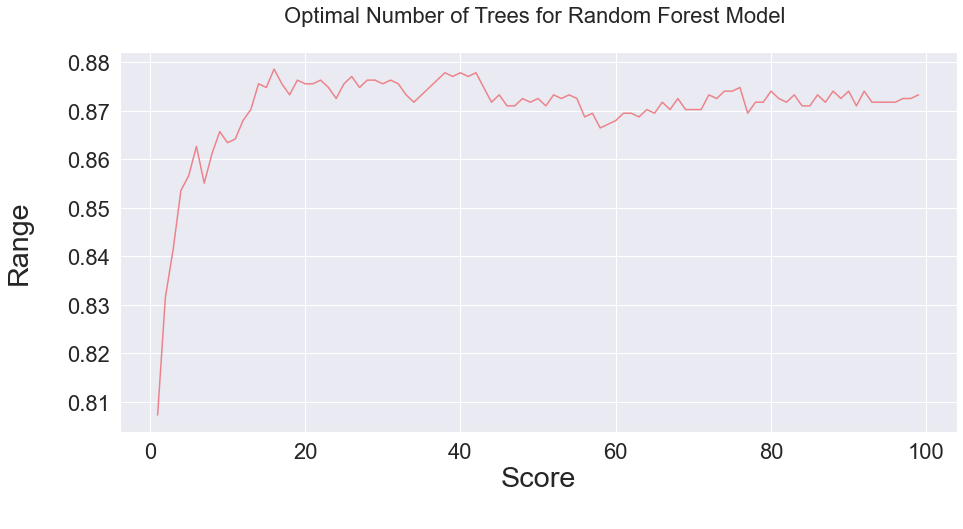

In [1150]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,100),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [1151]:
for i,j in enumerate(score_array):
    print(i+1,":",j)

1 : 0.8072837632776935
2 : 0.8315629742033384
3 : 0.8414264036418816
4 : 0.8535660091047041
5 : 0.8566009104704098
6 : 0.862670713201821
7 : 0.855083459787557
8 : 0.8611532625189682
9 : 0.8657056145675266
10 : 0.8634294385432474
11 : 0.8641881638846738
12 : 0.8679817905918058
13 : 0.870257966616085
14 : 0.8755690440060698
15 : 0.8748103186646434
16 : 0.8786039453717754
17 : 0.8755690440060698
18 : 0.8732928679817906
19 : 0.8763277693474962
20 : 0.8755690440060698
21 : 0.8755690440060698
22 : 0.8763277693474962
23 : 0.8748103186646434
24 : 0.8725341426403642
25 : 0.8755690440060698
26 : 0.8770864946889226
27 : 0.8748103186646434
28 : 0.8763277693474962
29 : 0.8763277693474962
30 : 0.8755690440060698
31 : 0.8763277693474962
32 : 0.8755690440060698
33 : 0.8732928679817906
34 : 0.8717754172989378
35 : 0.8732928679817906
36 : 0.8748103186646434
37 : 0.8763277693474962
38 : 0.877845220030349
39 : 0.8770864946889226
40 : 0.877845220030349
41 : 0.8770864946889226
42 : 0.877845220030349
43 : 0.

## SUPPORT VECTOR MACHINE



-----------------------------------------------------------
Accuracy of Support Vector Machine:  0.8566009104704098
Execution time: 1.13126159 seconds
-----------------------------------------------------------


<Figure size 432x288 with 0 Axes>

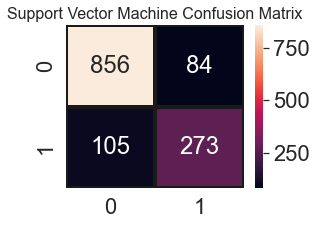

In [1152]:
# SUPPORT VECTOR MACHINE

svc_model = SVC(random_state = 42)

t0 = time.time()
svc_model.fit(X_train,y_train)
t1 = time.time()

accuracy_svc = svc_model.score(X_test,y_test)

print("\n\n-----------------------------------------------------------")
print("Accuracy of Support Vector Machine: ", accuracy_svc)
print("Execution time: %0.8f seconds" % (t1 - t0))
print("-----------------------------------------------------------")

svc_prediction = svc_model.predict(X_test)

plt.figure(13)
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, svc_prediction),
                annot=True, fmt = "d", linecolor="k", linewidths=3)


plt.title("Support Vector Machine Confusion Matrix", fontsize=16)
plt.show()

model_comparison = model_comparison.append(
    {'Model': 'Support Vector Machine',
     'Accuracy': accuracy_svc,
     'Execution time': '%0.8f seconds' % (t1 - t0)}, ignore_index = True)

## KNN

K-Nearest Neighbor (KNN) is a classification algorithm used for assigning a class to a new data point. K is an integer value specified by the user, and the classifier determines the class of a data point by the majority voting principle.

We trained two different KNN models, 
- Firstly, we chose the columns that we want to use in model comparison based on their relationships with customer status.
- Secondly, we use feature selection methods and train the model to see the accuracy with the best selected features.

#### KNN with 12 columns that we agreed to compare.



-----------------------------------------------------------
Accuracy of K-Nearest Neighbor:  0.8505311077389985
Execution time: 0.06596351 seconds
-----------------------------------------------------------


<Figure size 432x288 with 0 Axes>

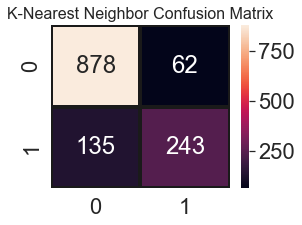

In [1153]:
knn_model = KNeighborsClassifier(n_neighbors = 10)

t0 = time.time()
knn_model.fit(X_train,y_train)
t1 = time.time()

accuracy_knn = knn_model.score(X_test,y_test)

print("\n\n-----------------------------------------------------------")
print("Accuracy of K-Nearest Neighbor: ", accuracy_knn)
print("Execution time: %0.8f seconds" % (t1 - t0))
print("-----------------------------------------------------------")

knn_prediction = knn_model.predict(X_test)

plt.figure(14)
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, knn_prediction),
                annot=True, fmt = "d", linecolor="k", linewidths=3)

plt.title("K-Nearest Neighbor Confusion Matrix", fontsize=16)
plt.show()

model_comparison = model_comparison.append(
    {'Model': 'K-Nearest Neighbor',
     'Accuracy': accuracy_knn,
     'Execution time': '%0.8f seconds' % (t1 - t0)}, ignore_index = True)

In [1154]:
score_array = []

for each in range(1,25):
    knn_loop = KNeighborsClassifier(n_neighbors = each) 
    knn_loop.fit(X_train,y_train)
    score_array.append(knn_loop.score(X_test,y_test))

score_array

[0.8095599393019727,
 0.8376327769347496,
 0.8505311077389985,
 0.8558421851289834,
 0.8581183611532626,
 0.8437025796661608,
 0.8482549317147192,
 0.8490136570561456,
 0.8490136570561456,
 0.8505311077389985,
 0.8505311077389985,
 0.8505311077389985,
 0.8474962063732928,
 0.8444613050075872,
 0.8444613050075872,
 0.8444613050075872,
 0.8467374810318664,
 0.8452200303490136,
 0.8452200303490136,
 0.8429438543247344,
 0.8490136570561456,
 0.8474962063732928,
 0.8490136570561456,
 0.8490136570561456]

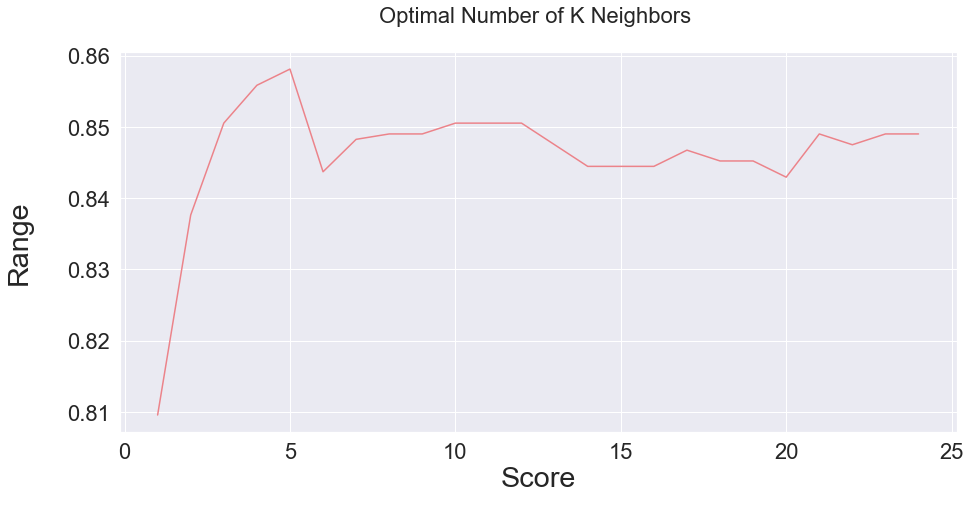

In [1155]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,25),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")

plt.title('Optimal Number of K Neighbors \n',horizontalalignment="center", fontstyle = "normal",fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")

plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

#### KNN feature selection and training

In [1156]:
data_df.columns

Index(['customerid', 'gender', 'age', 'married', 'number_of_dependents',
       'city', 'zipcode', 'latitude', 'longtitude', 'numberofreferrals',
       'tenureinmonths', 'offer', 'phoneservice',
       'avgmonthlylongdistancecharges', 'multiplelines', 'internetservice',
       'internettype', 'avgmonthlygbdownload', 'onlinesecurity',
       'onlinebackup', 'deviceprotectionplan', 'premiumtechsupport',
       'streamingtv', 'streamingmovies', 'streamingmusic', 'unlimiteddata',
       'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharge',
       'totalcharges', 'totalrefunds', 'totalextradatacharges',
       'totallongdistancecharges', 'totalrevenue', 'customerstatus',
       'churncategory', 'churnreason'],
      dtype='object')

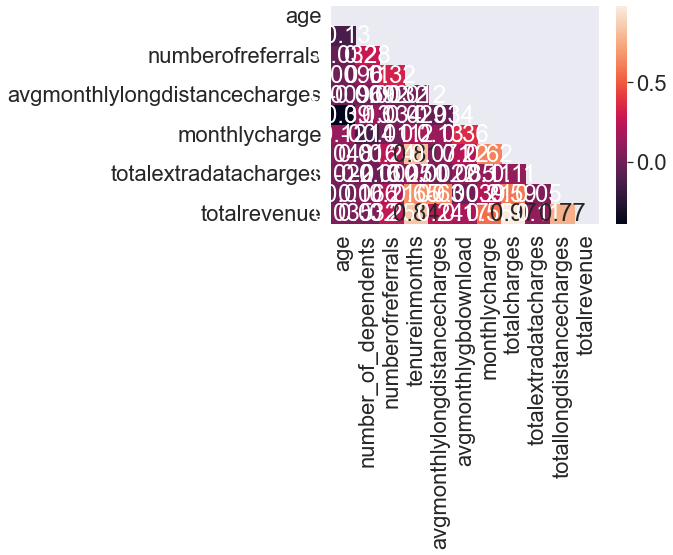

In [1157]:
# Feature Selection:
    # isolate x variables for feature selection tests
data_df_kd = data_df.copy()   
data_df_kd = data_df_kd.drop(['totalrefunds', 'paperlessbilling', 'zipcode', 'latitude', 'longtitude', 'city'],axis=1).set_index('customerid')

# Test of multicollinearity of numeric variables
# Isolate numeric variables for correlation analysis:
numeric_types_kd = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_numeric_kd = data_df_kd.select_dtypes(include=numeric_types_kd)

# Create correlation matrix for numeric features
corrmatrix_kd = X_numeric_kd.corr()
# sn.set(rc = {'figure.figsize':(15,8)})
mask_kd = np.triu(np.ones_like(corrmatrix_kd, dtype=bool))
sns.heatmap(corrmatrix_kd, mask=mask_kd, annot=True)
plt.show()

## ADABOOST

In [1158]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

adaHyperParams = {'n_estimators': [10,50,100,200,420], "learning_rate":  [0.001, 0.01, 0.1, 0.3]}
gridSearchAda = RandomizedSearchCV(estimator = classifier5, param_distributions = adaHyperParams, n_iter = 5,
                                   scoring = 'roc_auc') # other option accuracy
gridSearchAda.fit(X_train, y_train)

RandomizedSearchCV(estimator=AdaBoostClassifier(), n_iter=5,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.3],
                                        'n_estimators': [10, 50, 100, 200,
                                                         420]},
                   scoring='roc_auc')

In [1159]:
gridSearchAda.best_params_, gridSearchAda.best_score_

({'n_estimators': 50, 'learning_rate': 0.3}, 0.9280357337331366)

In [1160]:
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, y_train)

In [1161]:
# Getting the score AdaBoost
test_labels = bestAdaModFitted.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average = 'macro', sample_weight = None)

0.9390676010356862

In [1162]:
ABC = AdaBoostClassifier()

ABC_param_grid = {"n_estimators" :[10,50,100,200,420],
                  "learning_rate":  [0.001, 0.01, 0.1, 0.3]}

gsABC = GridSearchCV(ABC, param_grid = ABC_param_grid, cv = 10, scoring = "roc_auc", n_jobs = 6, verbose = 1)

gsABC.fit(X_train,y_train)

ada_best = gsABC.best_estimator_
print(ada_best)
print(gsABC.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
AdaBoostClassifier(learning_rate=0.1, n_estimators=420)
0.9294968810293194


In [1163]:
bestAdaModFitted2 = gsABC.best_estimator_.fit(X_train, y_train)

In [1164]:
test_labels = bestAdaModFitted2.predict_proba(np.array(X_test.values))[:,1]
roc_auc_score(y_test,test_labels , average = 'macro', sample_weight = None)

0.9399710120454801

## TENSORFLOW - deep learning

TensorFlow is a framework created by Google for creating Deep Learning models. Deep Learning is a category of machine learning models (=algorithms) that use multi-layer neural networks. Machine Learning has enabled us to build complex applications with great accuracy.

In [1165]:
tens_model = keras.Sequential([
    keras.layers.Dense(12, input_shape=(12,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

tens_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

tens_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
165/165 [==============================] - 1s 900us/step - loss: 0.6018 - accuracy: 0.6460
Epoch 2/10
165/165 [==============================] - 0s 839us/step - loss: 0.4761 - accuracy: 0.7173
Epoch 3/10
165/165 [==============================] - 0s 908us/step - loss: 0.4153 - accuracy: 0.7957
Epoch 4/10
165/165 [==============================] - 0s 859us/step - loss: 0.3740 - accuracy: 0.8340
Epoch 5/10
165/165 [==============================] - 0s 981us/step - loss: 0.3587 - accuracy: 0.8378
Epoch 6/10
165/165 [==============================] - 0s 786us/step - loss: 0.3499 - accuracy: 0.8391
Epoch 7/10
165/165 [==============================] - 0s 875us/step - loss: 0.3429 - accuracy: 0.8433
Epoch 8/10
165/165 [==============================] - 0s 820us/step - loss: 0.3388 - accuracy: 0.8458
Epoch 9/10
165/165 [==============================] - 0s 890us/step - loss: 0.3368 - accuracy: 0.8461
Epoch 10/10
165/165 [==============================] - 0s 798us/step - loss: 0.335

In [1166]:
tens_model.evaluate(X_test, y_test)

42/42 [==============================] - 0s 658us/step - loss: 0.3117 - accuracy: 0.8566


[0.3116985261440277, 0.8566009402275085]

In [1167]:
tens_pred = tens_model.predict(X_test)
y_pred = []
for element in tens_pred:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred[:10]

[0, 1, 0, 1, 1, 0, 0, 0, 1, 1]

In [1168]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       940
           1       0.76      0.74      0.75       378

    accuracy                           0.86      1318
   macro avg       0.83      0.82      0.82      1318
weighted avg       0.86      0.86      0.86      1318



42/42 [==============================] - 0s 1ms/step - loss: 0.3117 - accuracy: 0.8566


-----------------------------------------------------------
Accuracy of Tensor flow:  [0.3116985261440277, 0.8566009402275085]
Execution time: 0.06596351 seconds
-----------------------------------------------------------


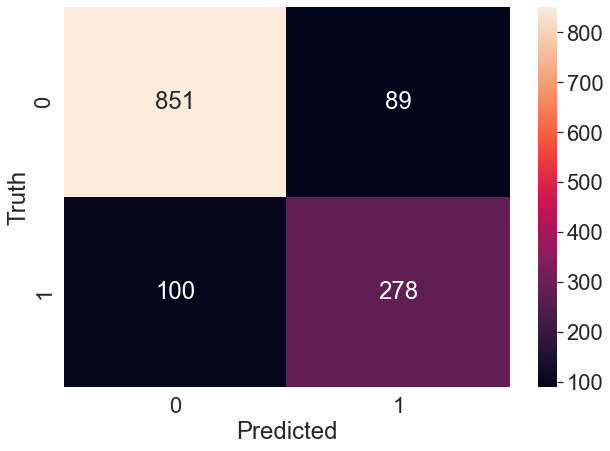

In [1169]:
accuracy_tensor_flow = tens_model.evaluate(X_test,y_test)

print("\n\n-----------------------------------------------------------")
print("Accuracy of Tensor flow: ", accuracy_tensor_flow)
print("Execution time: %0.8f seconds" % (t1 - t0))
print("-----------------------------------------------------------")


cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

model_comparison = model_comparison.append(
    {'Model': 'Tensor Flow Classifier',
     'Accuracy': accuracy_tensor_flow,
     'Execution time': '%0.8f seconds' % (t1 - t0)}, ignore_index = True)

## FINAL EVALUATION

In [1170]:
model_comparison

Model                                  Accuracy  \
0            Logistic Model                                  0.852807   
1  Decision Tree Classifier                                  0.827011   
2  Random Forest Classifier                                  0.882398   
3    Support Vector Machine                                  0.856601   
4        K-Nearest Neighbor                                  0.850531   
5    Tensor Flow Classifier  [0.3116985261440277, 0.8566009402275085]   

       Execution time  
0  0.00499630 seconds  
1  0.01798844 seconds  
2  2.43604422 seconds  
3  1.13126159 seconds  
4  0.06596351 seconds  
5  0.06596351 seconds

In [1171]:


#evaluation of results
def model_evaluation(y_test, y_pred, model_name):
    acc     = accuracy_score(y_test, y_pred)
    prec    = precision_score(y_test, y_pred)
    rec     = recall_score(y_test, y_pred)
    f1      = f1_score(y_test, y_pred)
    f2      = fbeta_score(y_test, y_pred, beta = 2.0)

    results = pd.DataFrame([[model_name, acc, prec, rec, f1, f2]], 
                       columns = ["Model", "Accuracy", "Precision", "Recall","F1 SCore", "F2 Score"])
    results = results.sort_values(["Precision", "Recall", "F2 Score"], ascending = False)
    return results

In [1172]:
# Logistic regression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

#knn
classifier2 = KNeighborsClassifier(n_neighbors=22, metric="minkowski", p=2)
classifier2.fit(X_train, y_train)
y_pred2 = classifier2.predict(X_test)

#Decision tree
classifier3 = DecisionTreeClassifier(criterion="entropy", random_state=0)
classifier3.fit(X_train, y_train)
y_pred3 = classifier3.predict(X_test)

#Random Forest

classifier4 = RandomForestClassifier(n_estimators=72, criterion="entropy", random_state=0)
classifier4.fit(X_train, y_train)
y_pred4 = classifier4.predict(X_test)

#Adaboost
classifier5 = AdaBoostClassifier()
classifier5.fit(X_train, y_train)
y_pred5 = classifier5.predict(X_test)




In [1173]:
tens_pred = tens_model.predict(X_test)
y_pred6 = []
for element in tens_pred:
    if element > 0.5:
        y_pred6.append(1)
    else:
        y_pred6.append(0)
y_pred6[:10]

[0, 1, 0, 1, 1, 0, 0, 0, 1, 1]

In [1174]:
lr  = model_evaluation(y_test, y_pred, "Logistic Regression")
knn = model_evaluation(y_test, y_pred2, "K-Nearest Neighbours")
dt  = model_evaluation(y_test, y_pred3, "Decision Tree")
rf  = model_evaluation(y_test, y_pred4, "Random Forest")
ab  = model_evaluation(y_test, y_pred5, "Adaboost")


In [ ]:
eval_ =lr.append(knn).append(dt).append(rf).append(ab).sort_values(["Precision", "Recall", "F2 Score"], ascending = False).reset_index().drop(columns = "index")
eval_

Model  Accuracy  Precision    Recall  F1 SCore  F2 Score
0         Random Forest  0.873293   0.820669  0.714286  0.763791  0.733297
1              Adaboost  0.873293   0.798867  0.746032  0.771546  0.756032
2  K-Nearest Neighbours  0.847496   0.772308  0.664021  0.714083  0.683179
3   Logistic Regression  0.855083   0.739130  0.764550  0.751625  0.759327
4         Decision Tree  0.826252   0.692506  0.708995  0.700654  0.705635

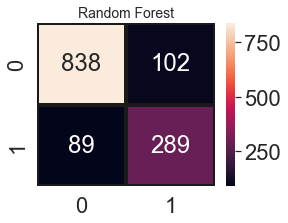

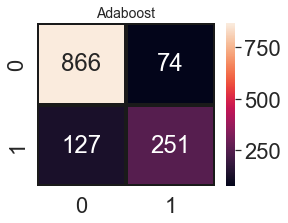

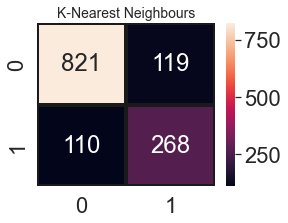

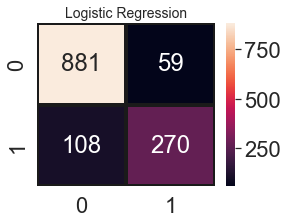

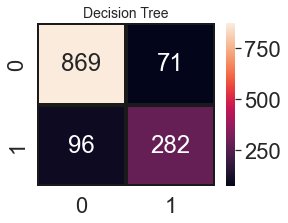

In [ ]:
predictions = [y_pred, y_pred2 , y_pred3, y_pred4, y_pred5]

for i, j in zip(predictions, eval_.Model.values):
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, i),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
    plt.title(j,fontsize=14)
    plt.show()

In [ ]:
def k_fold_cross_validation(classifier_name, name):
    accuracies = cross_val_score(estimator=classifier_name, X=X_train, y=y_train, cv =10)
    print(name, "accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

In [ ]:
k_fold_cross_validation(classifier5, "Adaboost")

Adaboost accuracy: 0.86 (+/- 0.03)


In [ ]:
k_fold_cross_validation(classifier, "Logistic regression")

Logistic regression accuracy: 0.84 (+/- 0.03)


In [ ]:
k_fold_cross_validation(classifier3, "Decision Tree")

Decision Tree accuracy: 0.83 (+/- 0.03)


In [ ]:
# ROC Curve

def ROC_curve(classifier_, name, y_pred_):
    classifier_.fit(X_train, y_train) 
    probs = classifier_.predict_proba(X_test) 
    probs = probs[:, 1] 
    classifier_roc_auc = roc_auc_score(y_test, probs )
    rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier_.predict_proba(X_test)[:,1])
    plt.figure(figsize=(14, 6))

    label_ = name + '(area = %0.2f)' % classifier_roc_auc
    # Plot Adaboost ROC
    plt.plot(rf_fpr, rf_tpr, 
    label=label_)
    # Plot Base Rate ROC
    plt.plot([0,1], [0,1],label='Base Rate' 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate \n',horizontalalignment="center",
    fontstyle = "normal", fontsize = "medium", 
    fontfamily = "sans-serif")

    plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
    fontstyle = "normal", fontsize = "medium", 
    fontfamily = "sans-serif")

    plt.title('ROC Graph \n',horizontalalignment="center", 
    fontstyle = "normal", fontsize = "22", 
    fontfamily = "sans-serif")

    plt.legend(loc="lower right", fontsize = "medium")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")
    plt.show()

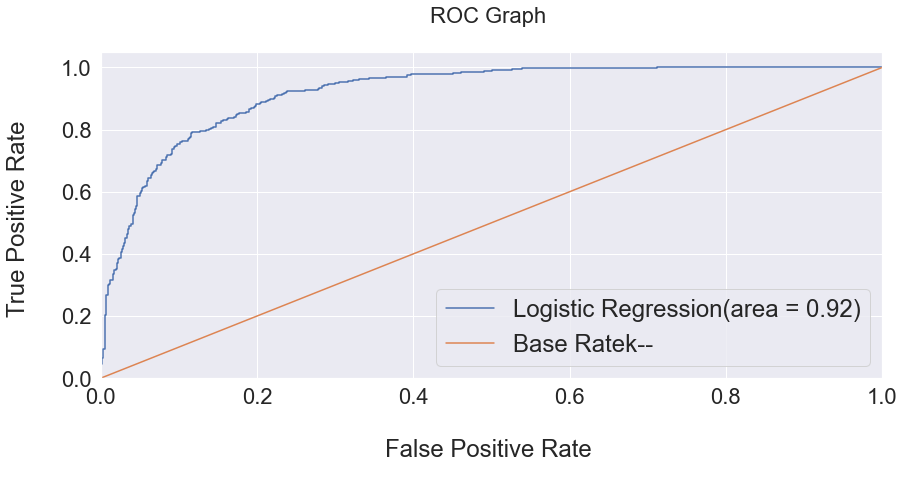

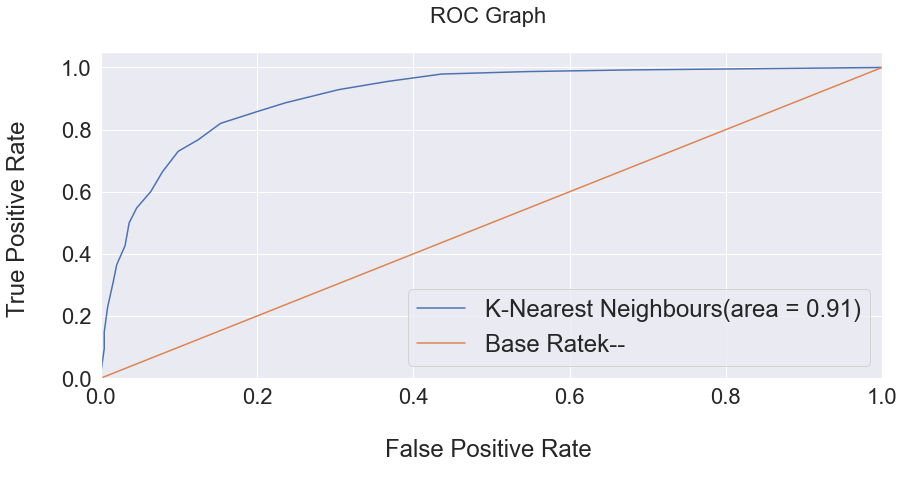

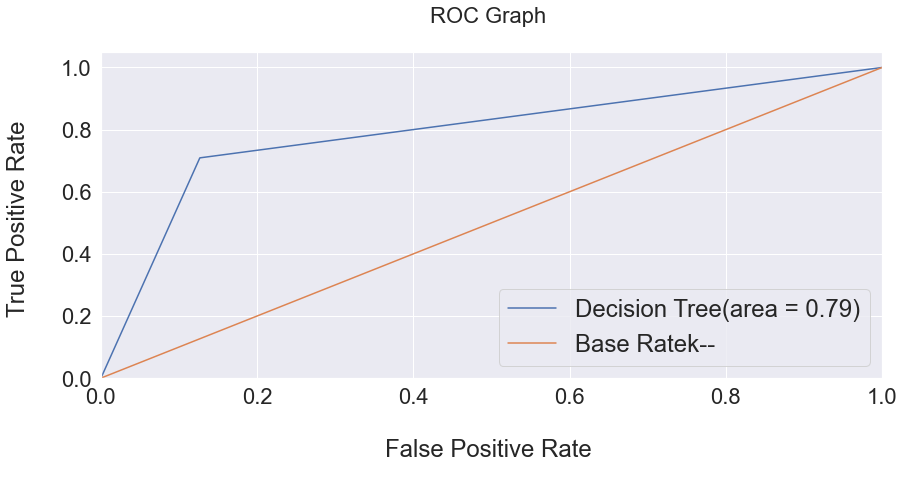

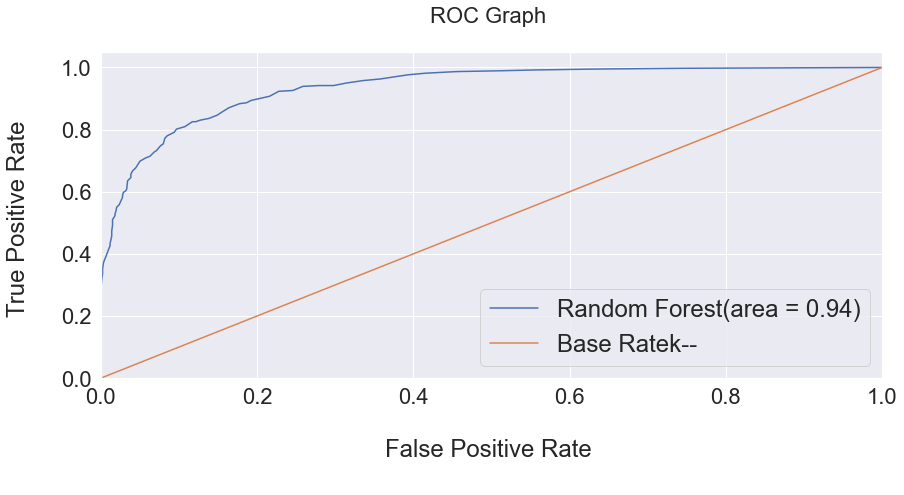

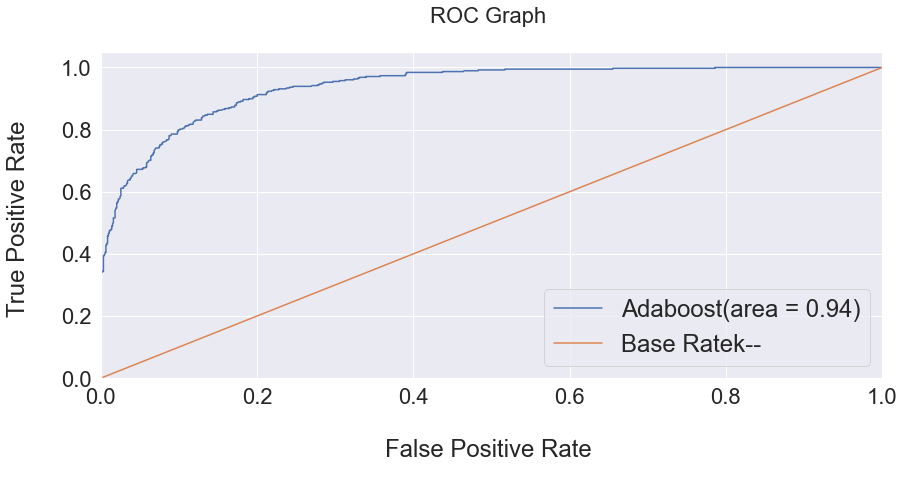

In [ ]:
preds = [y_pred, y_pred2,  y_pred3, y_pred4, y_pred5]
classifiers = [classifier , classifier2, classifier3, classifier4, classifier5]
model_names_ = ["Logistic Regression",  "K-Nearest Neighbours", "Decision Tree", "Random Forest", "Adaboost" ]

for i, j, k in zip(classifiers, model_names_, predictions):
    ROC_curve(i, j, k) 

In [ ]:
# Cross validation

from sklearn.model_selection import cross_val_score

# Function that will track the mean value and the standard deviation of the accuracy
def cvDictGen(functions, scr, X_train = X, y_train = y, cv = 5):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv = cv, scoring = scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

In [ ]:
cvD = cvDictGen(classifiers, scr = 'roc_auc')
cvD

{'LogisticRegression': [0.9045060528869155, 0.007206214445954245],
 'KNeighborsClassifier': [0.8872015184643486, 0.009815783814127338],
 'DecisionTreeClassifier': [0.786723346594387, 0.011154718005278947],
 'RandomForestClassifier': [0.9254203633311618, 0.006726852292467544],
 'AdaBoostClassifier': [0.9281746461808822, 0.003899109301168295]}

In [ ]:
# Ada boost classifier
feature_importances = pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
                                 pd.DataFrame(np.transpose(classifier5.feature_importances_), columns = ["coef"])],axis = 1)
feature_importances.sort_values(by = "coef", ascending = False)

features  coef
11         monthlycharge  0.32
3      numberofreferrals  0.20
7         tenureinmonths  0.16
0                    age  0.08
8               contract  0.08
6     premiumtechsupport  0.04
9   number_of_dependents  0.04
1                married  0.02
4                  offer  0.02
5         onlinesecurity  0.02
10      paperlessbilling  0.02
2          unlimiteddata  0.00

In [ ]:
# Comparing performance of the 5 models
# UPDATE THE NUMBERS DD

performance = {'Model': ['Adaboost', 'Logistic Regression', 'Random Forest', 'K-Nearest Neighbours', 'Decision Tree'], 
               'Accuracy (%)': [81.23, 80.56, 79.66, 78.91, 73.27], 
               'Precision (%)': [68.79, 65.82, 65.06, 62.88, 49.73], 
               'F2 Score(%)': [56.28, 57.69, 53.13, 52.52, 50.30]
              }
perf = pd.DataFrame(data=performance)
perf

Model  Accuracy (%)  Precision (%)  F2 Score(%)
0              Adaboost         81.23          68.79        56.28
1   Logistic Regression         80.56          65.82        57.69
2         Random Forest         79.66          65.06        53.13
3  K-Nearest Neighbours         78.91          62.88        52.52
4         Decision Tree         73.27          49.73        50.30

In [ ]:
perf = perf.set_index('Model')

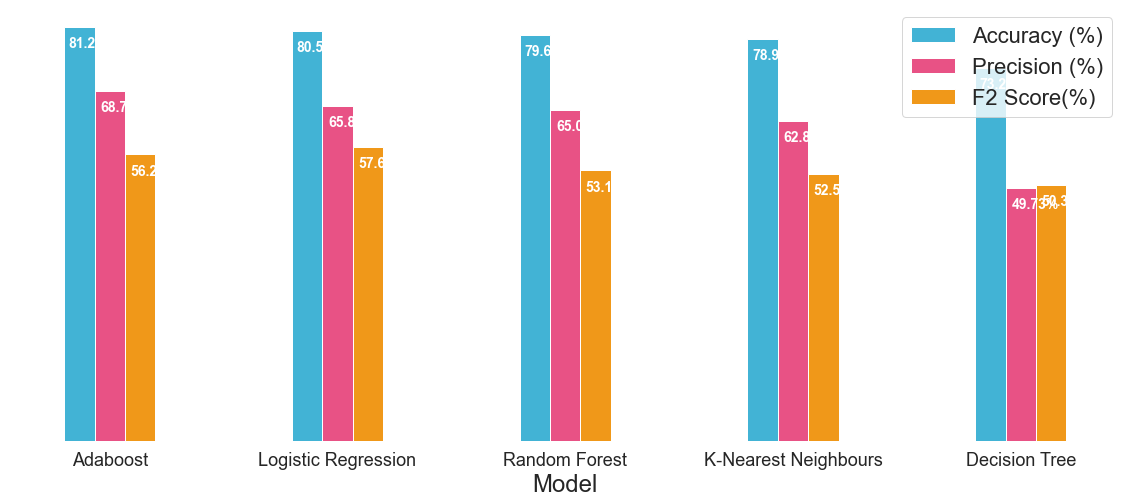

In [ ]:
sns.set_style(style='white')

ax = perf.plot(kind='bar', figsize=(20,8), width=0.4, color=['#42b3d5', '#e85285', '#f09819'], fontsize=18)

ax.legend(loc='best')
plt.xticks(rotation=0, ha="center")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(False)
ax.spines['left'].set_linewidth(False)

ax.get_yaxis().set_visible(False)

for n in range(3):
    for index, val in enumerate(perf.iloc[:,n].transpose()): 
        label=str(val) + '%'
        
        if n==0:
            ax.annotate(label, xy=(index - 0.18, val-4), color='#ffffff', fontsize=14, fontweight='bold')
        elif n==1:
            ax.annotate(label, xy=(index - 0.04, val-4), color='#ffffff', fontsize=14, fontweight='bold')
        elif n==2:
            ax.annotate(label, xy=(index + 0.09, val-4), color='#ffffff', fontsize=14, fontweight='bold')

#  Drawing conclusions — Summary

We have walked through a complete end-to-end machine learning project using the Telco customer Churn dataset. We started by cleaning the data and analyzing it with visualization. Then, to be able to build a machine learning model, we transformed the categorical data into numeric variables (feature engineering). After transforming the data, we tried 5 different machine learning algorithms using default parameters. Finally, we tuned the hyperparameters of the Adaboost (best performance model) for model optimization, obtaining an accuracy of nearly 81%.
